In [ ]:
# for getting chemcial properties
!pip install rdkit
!pip install git+https://github.com/lmmentel/mendeleev.git@v0.11.0

# torch_geometric lib
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 594 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lmmentel/mendeleev.git (to revision v0.11.0) to /tmp/pip-req-build-69xe8q7q
  Running command git clone -q https://github.com/lmmentel/mendeleev.git /tmp/pip-req-build-69xe8q7q
  Running command git checkout -q 9a77d402b82e34a7fdce204509314d8989ceefff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 4.2 MB/s 
     |████████████████████████████████| 865 kB 90.6 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.11.0-py3-none-any.whl size=296445 sha256=6a7240f49d6dd847b54578f2c683317eda501f6579ce436eb3ac830bb6f5dda6
  Stored in directory: /tmp/pip-ephem-wheel-cache-jfrvvnzm/wheel

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 13.4 MB/s 
     |████████████████████████████████| 4.6 MB 4.9 MB/s 
     |████████████████████████████████| 280 kB 4.1 MB/s 


In [ ]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric as geo
import torch_geometric.utils
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# 1 data load

models : GCN, GCN+a, GCN+g, GCN+a+g, GGNN

property : logP, TPSA, SAS (ZINC dataset) and pve (CEP dataset)



> The node features correspond to atom
descriptors including atom type, number of attached hydrogens,
number of valencies, and aromaticity indicator. We represent all
the descriptors with an one-hot encoded vector.



## 1-1 generating feature matrix via the paper way

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem.QED import qed
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Contrib.SA_Score.sascorer import calculateScore


atomSymbolz = ['Ag', 'Al', 'As', 'Au', 'B', 'Br', 'C', 'Ca', 'Cd', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ge', 'H', 'Hg', 'I', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'Ni', 'O', 'P', 'Pb', 'Pd', 'Pt', 'S', 'Sb', 'Se', 'Si', 'Sn', 'Ti', 'Tl', 'V', 'Zn']


def make_onehot_features(atom):
  ret = []
  ret += list(map(lambda r: r == atom.GetSymbol(), atomSymbolz))
  ret += list(map(lambda r: r == atom.GetDegree(), (0,1,2,3,4,5)))
  ret += list(map(lambda r: r == atom.GetImplicitValence(), (0,1,2,3,4,5)))
  ret += [1 if atom.GetIsAromatic() else 0]

  return np.array(ret) # (atom X 53)

def get_targetProperties(mol):
  l       = torch.tensor(MolLogP(mol), dtype=torch.float).view(1,1)
  t       = torch.tensor(CalcTPSA(mol), dtype=torch.float).view(1,1)
  q       = torch.tensor(qed(mol), dtype=torch.float).view(1,1)
  s       = torch.tensor(calculateScore(mol) , dtype=torch.float).view(1,1)

  return l, t, q, s

# for smiles in tqdm_notebook(SMILES):

def molToData(mol):
  max_atoms = 55

  adj = Chem.GetAdjacencyMatrix(mol) # return np.ndarray (N x N)
  N = adj.shape[0]
  self_added_adj = adj + np.eye(N, dtype=np.int32) # self node information

  padded_adj = np.zeros((max_atoms, max_atoms))
  padded_adj[:N, :N] = self_added_adj

  # edge_idx = torch.tensor(adj).to_sparse() !! ERR !!
  bonds = []
  for i in range(mol.GetNumAtoms()):
    for j in range(mol.GetNumAtoms()):
      if adj[i,j] == 1:
        bonds.append([i,j])

  # get feature X
  atomic_f = []
  padded_atomic_f = []

  pad = np.zeros((max_atoms, 53))
  temp_atomic_f = []

  for atom in mol.GetAtoms():
    onehot_f = make_onehot_features(atom)
    temp_atomic_f.append(onehot_f)
    atomic_f.append(onehot_f)

  pad[:len(temp_atomic_f), :] = temp_atomic_f
  padded_atomic_f.append(pad)

  padded_atomic_f = np.array(padded_atomic_f)
  atomic_f        = np.array(atomic_f)

  # converting
  atomic_f = torch.tensor(atomic_f, dtype=torch.float)
  bonds    = torch.tensor(bonds, dtype=torch.long).t().contiguous()
  padded_atomic_f = torch.tensor(padded_atomic_f, dtype=torch.float)
  padded_adj = torch.tensor(padded_adj, dtype=torch.float)

  return atomic_f, bonds, padded_atomic_f, padded_adj

def load_ZINCdataset1(dataPath):
  f = open(dataPath)
  SMILES = f.readlines()

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for smiles in tqdm(SMILES[:10000]):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, bonds, padded_atomic_f, padded_adj = molToData(mol)
    logP, tpsa, qed, sas = get_targetProperties(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=logP, edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f, smiles=smiles,
                            LogP=logP, TPSA=tpsa, QED=qed, SAS=sas)],
                     dtype=object)
                    )

  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  return data_list

def load_CEPdataset1(dataPath, valuePath):
  f = open(dataPath)
  SMILES = f.readlines()

  values = np.load(valuePath)
  values = values.astype(np.float64)
  values = torch.tensor(values, dtype=torch.float).view(-1, 1)

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for idx, smiles in tqdm(enumerate(SMILES[:10000])):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, bonds, padded_atomic_f, padded_adj = molToData(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=values[idx].view(1,1), edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f, smiles=smiles)],
                     dtype=object)
                    )
  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  return data_list


## 1-2 variation of the features

In [ ]:
def get_atomicFeature_table():
  from mendeleev.fetch import fetch_table
  ptable = fetch_table('elements')
  ptable = ptable.select_dtypes(include=np.number)

  feature_labels = ['atomic_number','atomic_weight', 'atomic_radius', 'atomic_volume', 'dipole_polarizability',
                   'vdw_radius', 'en_pauling','boiling_point', 'electron_affinity',
                   'en_allen', 'en_ghosh']


  ret = ptable[feature_labels].to_numpy(copy=True)
  del ptable

  return ret

def get_molecluarProperty(mol):
  from rdkit.Chem import Descriptors

  MolWt                     = rdkit.Chem.Descriptors.MolWt(mol)
  HeavyAtomMolWt            = rdkit.Chem.Descriptors.HeavyAtomMolWt(mol)
  NumValenceElectrons       = rdkit.Chem.Descriptors.NumValenceElectrons(mol)
  FractionCSP3              = rdkit.Chem.Lipinski.FractionCSP3(mol)
  HeavyAtomCount            = rdkit.Chem.Lipinski.HeavyAtomCount(mol)
  NHOHCount                 = rdkit.Chem.Lipinski.NHOHCount(mol)
  NOCount                   = rdkit.Chem.Lipinski.NOCount(mol)
  NumAliphaticCarbocycles   = rdkit.Chem.Lipinski.NumAliphaticCarbocycles(mol)
  NumAliphaticHeterocycles  = rdkit.Chem.Lipinski.NumAliphaticHeterocycles(mol)
  NumAliphaticRings         = rdkit.Chem.Lipinski.NumAliphaticRings(mol)
  NumAromaticCarbocycles    = rdkit.Chem.Lipinski.NumAromaticCarbocycles(mol)
  NumAromaticHeterocycles   = rdkit.Chem.Lipinski.NumAromaticHeterocycles(mol)
  NumAromaticRings          = rdkit.Chem.Lipinski.NumAromaticRings(mol)
  NumHAcceptors             = rdkit.Chem.Lipinski.NumHAcceptors(mol)
  NumHDonors                = rdkit.Chem.Lipinski.NumHDonors(mol)
  NumHeteroatoms            = rdkit.Chem.Lipinski.NumHeteroatoms(mol)
  NumRotatableBonds         = rdkit.Chem.Lipinski.NumRotatableBonds(mol)
  RingCount                 = rdkit.Chem.Lipinski.RingCount(mol)
  MolMR                     = rdkit.Chem.Crippen.MolMR(mol)

  x = np.array([MolWt, HeavyAtomMolWt, NumValenceElectrons, FractionCSP3, HeavyAtomCount, NHOHCount, NOCount, NumAliphaticCarbocycles, NumAliphaticHeterocycles, NumAliphaticRings, NumAromaticCarbocycles, NumAromaticHeterocycles, NumAromaticRings, NumHAcceptors, NumHDonors, NumHeteroatoms, NumRotatableBonds, RingCount, MolMR])

  return x

def dataFromMol(mol):
  max_atoms = 55

  adj = Chem.GetAdjacencyMatrix(mol) # return np.ndarray (N x N)
  N = adj.shape[0]
  self_added_adj = adj + np.eye(N, dtype=np.int32) # self node information

  padded_adj = np.zeros((max_atoms, max_atoms))
  padded_adj[:N, :N] = self_added_adj

  # edge_idx = torch.tensor(adj).to_sparse() !! ERR !!
  bonds = []
  for i in range(mol.GetNumAtoms()):
    for j in range(mol.GetNumAtoms()):
      if adj[i,j] == 1:
        bonds.append([i,j])

  # get feature X
  f_table = get_atomicFeature_table()
  atomic_f = []
  padded_atomic_f = []

  pad = np.zeros((max_atoms, 15))
  temp_atomic_f = []

  for atom in mol.GetAtoms():
    value_f = np.concatenate([f_table[atom.GetAtomicNum()-1, :],
                                    [atom.GetTotalNumHs(),
                                    atom.GetDegree(),
                                    atom.GetImplicitValence(),
                                    atom.GetIsAromatic() * 1]])

    temp_atomic_f.append(value_f)
    atomic_f.append(value_f)

  pad[:len(temp_atomic_f), :] = temp_atomic_f
  padded_atomic_f.append(pad)

  padded_atomic_f = np.array(padded_atomic_f)
  atomic_f        = np.array(atomic_f)

  mol_f = get_molecluarProperty(mol)

  # converting
  atomic_f = torch.tensor(atomic_f, dtype=torch.float)
  mol_f    = torch.tensor(mol_f, dtype=torch.float).view(1,-1)
  bonds    = torch.tensor(bonds, dtype=torch.long).t().contiguous()
  padded_atomic_f = torch.tensor(padded_atomic_f, dtype=torch.float)
  padded_adj = torch.tensor(padded_adj, dtype=torch.float)

  return atomic_f, mol_f, bonds, padded_atomic_f, padded_adj


def normalize_feature(data):
  def standarize(src_data):
    means = src_data.mean(dim=0, keepdim=True)
    stds  = src_data.std(dim=0, keepdim=True)

    return means, stds

  atomic_f = []
  padded_atomic_f = []
  mol_f = []

  for one in data:
    atomic_f.append(one.x)
    mol_f.append(one.mol_f)
    padded_atomic_f.append(one.shaped_x)

  atomic_f = torch.cat(atomic_f, dim=0)
  mol_f    = torch.cat(mol_f, dim=0)
  padded_atomic_f = torch.cat(padded_atomic_f, dim=0)

  a_means, a_stds = standarize(atomic_f)
  m_means, m_stds = standarize(mol_f)


  for idx, one in enumerate(data):
    one.x = (one.x - a_means) / a_stds
    one.mol_f  = (one.mol_f - m_means) / m_stds
    one.shaped_x = (one.shaped_x - a_means) / a_stds

  return data

def load_ZINCdataset2(dataPath):
  f = open(dataPath)
  SMILES = f.readlines()

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for smiles in tqdm(SMILES[:10000]):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, mol_f, bonds, padded_atomic_f, padded_adj = dataFromMol(mol)
    logP, tpsa, qed, sas = get_targetProperties(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=logP, edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f,
                            smiles=smiles, mol_f=mol_f,
                            LogP=logP, TPSA=tpsa, QED=qed, SAS=sas)],
                     dtype=object)
                    )

  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  ## scale is matter
  data_list[:, 1] = normalize_feature(data_list[:, 1])

  return data_list

def load_CEPdataset2(dataPath, valuePath):
  f = open(dataPath)
  SMILES = f.readlines()

  values = np.load(valuePath)
  values = values.astype(np.float64)
  values = torch.tensor(values, dtype=torch.float).view(-1, 1)

  print(f'# of SMILES data: {len(SMILES)}')

  data_list = []

  for idx, smiles in tqdm(enumerate(SMILES[:10000])):
    mol = Chem.MolFromSmiles(smiles.strip())

    atomic_f, mol_f, bonds, padded_atomic_f, padded_adj = dataFromMol(mol)

    data_list.append(
                      np.array([smiles,
                      Data(x=atomic_f, y=values[idx].view(1,1), edge_index=bonds,
                            adj=padded_adj, shaped_x=padded_atomic_f,
                            smiles=smiles, mol_f=mol_f)],
                     dtype=object)
                    )
  data_list = np.array(data_list) # (N x 2; SMILES, DATA)

  data_list[:, 1] = normalize_feature(data_list[:, 1])

  return data_list


# 2 model implementation

## 2-1 GatedSkipConnection (GATE) & SkipConnection

In [ ]:
class GatedSkipConnection(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(GatedSkipConnection, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim

    if self.input_dim is not self.output_dim:
      self.proj = nn.Linear(self.input_dim, self.output_dim, bias=False)
    self.U1 = nn.Linear(self.output_dim, self.output_dim)
    self.U2 = nn.Linear(self.output_dim, self.output_dim)

    self.sigmoid = nn.Sigmoid()


  def get_gateCoef(self, f_x, id_x):
    h1 = self.U1(f_x)
    h2 = self.U2(id_x)

    output = self.sigmoid(h1 + h2)

    return output

  def forward(self, f_x, id_x):

    if self.input_dim is not self.output_dim:
      id_x = self.proj(id_x)

    z = self.get_gateCoef(f_x, id_x)
    output = z * f_x + (1.0 - z) * id_x

    return output

class SkipConnection(nn.Module):
  def __init__(self, input_dim, output_dim, concat=False):
    super(SkipConnection, self).__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim
    self.concat = concat

    if self.input_dim is not self.output_dim:
      self.proj = nn.Linear(input_dim, output_dim, bias=False)

  def forward(self, f_x, id_x):
    if self.input_dim is not self.output_dim:
      id_x = self.proj(id_x)

    if self.concat:
      output = torch.cat([f_x, id_x], dim=1)
    else:
      output = f_x + id_x

    return output

## 2-2 Graph Convolutional Networks

**1 Attention and gate-augmented graph convoutional networks**
- Graph Convolutional Networks (GCN) with skip connection
- Graph Convolutional Networks (GCN) with gated skip connection
- Graph Attention Networks (GAT) with skip connection
- Graph Attention Networks (GAT) with gated skip connection

**2 Graph Isomorphic Networks**
- Graph Isomorphic Networks (GIN)
- Graph Convolution Netowkrs (GCN)
- Graph SAmple and aggreGatE (SAGE); mean aggregator version

**3 Modified SAGE layer**



---



### 1) Attention and Gate-augmented Graph Convutional Networks

1. GCNwithSkip
2. GCNwithGATE
3. GATwithSkip
4. GATwithGATE

In [ ]:
class GCNlayer(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(GCNlayer, self).__init__()

    self.linear = nn.Linear(input_dim, output_dim)
    # self.norm   = nn.BatchNorm1d(55)

  def forward(self, x, adj):
    h = self.linear(x)
    output = torch.matmul(adj, h)
    # h = self.norm(h)

    return output

In [ ]:
class GINlayer(nn.Module):
  def __init__(self, mlp, input_dim, output_dim, eps=0):
    super(GCNlayer, self).__init__()

    self.mlp = mlp
    if eps:
      self.eps = nn.Parameter(torch.Tensor((eps)))
    else:
      self.eps = None


  def forward(self, x, adj):

    if self.eps is not None:
      # A + (1+eps) * I
      adj = adj - torch.eye(adj.shape[0], dtype=torch.float)
      eye = torch.eye(adj.shape[0], dtype=torch.float)
      adj = adj + (1 + self.eps) * eye

    h = torch.matmul(adj, x)
    output = self.mlp(h)

    return output

In [ ]:
class GCNwithSkip(nn.Module):
  def __init__(self, args):
    super(GCNwithSkip, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GCNlayer(args.input_dim, args.hidden_dim)
    self.conv2 = GCNlayer(args.hidden_dim, args.hidden_dim)
    self.conv3 = GCNlayer(args.hidden_dim, args.hidden_dim)

    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = SkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = SkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()

  def forward(self, G):

    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])

    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3)

    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)

    output = self.mlp(readout)

    return output


In [ ]:
class GCNwithGate(nn.Module):
  def __init__(self, args):
    super(GCNwithGate, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GCNlayer(args.input_dim, args.hidden_dim)
    self.conv2 = GCNlayer(args.hidden_dim, args.hidden_dim)
    self.conv3 = GCNlayer(args.hidden_dim, args.hidden_dim)

    self.skip1 = GatedSkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim , args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()

  def forward(self, G):

    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])

    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3)

    # h3:(B, atom, 32) -> readout(h3): (B, atom, 512) -> readout:(B, 512)
    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)

    output = self.mlp(readout)

    return output


In [ ]:
# multihead attention
class GATlayer(nn.Module):
  def __init__(self, input_dim, output_dim, head_num):
    super(GATlayer, self).__init__()
    self.W1 = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(head_num)])
    self.att_weight = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(head_num)])
    self.act = nn.ReLU()
    self.head_num = head_num

  def attention(self, x, adj):
    attn = []
    for layer in self.att_weight:
      h = layer(x)
      ch = torch.matmul(h.transpose(1,2), adj)
      hch = torch.matmul(h, ch)
      attn.append(torch.tanh(hch))

    return attn

  def forward(self, x, adj):
    attns = self.attention(x, adj)
    outputs = []
    for i in range (len(attns)):
      h = self.W1[i](x)
      outputs.append(torch.matmul(attns[i],h))
    outputs = torch.stack(outputs)
    output = torch.sum(outputs, dim=0, keepdim=False)
    output /= self.head_num
    output = self.act(output)

    return output

In [ ]:
class GATwithSkip(nn.Module):
  def __init__(self, args):
    super(GATwithSkip, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GATlayer(args.input_dim, args.hidden_dim, args.head_num)
    self.conv2 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)
    self.conv3 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)

    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = SkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = SkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()

  def forward(self, G):

    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])

    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3)

    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)

    output = self.mlp(readout)

    return output

In [ ]:
class GATwithGate(nn.Module):
  def __init__(self, args):
    super(GATwithGate, self).__init__()

    self.mol_dim = args.mol_dim

    self.conv1 = GATlayer(args.input_dim, args.hidden_dim, args.head_num)
    self.conv2 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)
    self.conv3 = GATlayer(args.hidden_dim, args.hidden_dim, args.head_num)

    self.skip1 = GatedSkipConnection(args.input_dim, args.hidden_dim)
    self.skip2 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)
    self.skip3 = GatedSkipConnection(args.hidden_dim, args.hidden_dim)

    self.readout = nn.Linear(args.hidden_dim, args.latent_dim)

    self.mlp = nn.Sequential(
        nn.Linear(args.latent_dim + args.mol_dim , args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, args.latent_dim),
        nn.ReLU(),
        nn.Linear(args.latent_dim, 1)
    )

    self.act = nn.ReLU()

  def forward(self, G):

    edge = G.adj.reshape(G.batch.max().item() +1, -1 , G.adj.shape[-1])
    x = G.shaped_x.reshape(G.batch.max().item() +1, -1 , G.x.shape[-1])

    id1 = x
    h1 = self.conv1(x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1, edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3)

    # h3:(B, atom, 32) -> readout(h3): (B, atom, 512) -> readout:(B, 512)
    readout = torch.sum(self.readout(h3), 1)

    if self.mol_dim >0 :
      readout = torch.cat( (readout, G.mol_f), dim=1)

    output = self.mlp(readout)

    return output

### 2) Graph Isomorphic Netwokrs
1. GIN
2. GCN
3. SAGE

In [ ]:
class MLPcell(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(MLPcell, self).__init__()

    self.mlp = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
    )

  def forward(self, x):

    output = self.mlp(x)

    return output

In [ ]:
class GIN(nn.Module):
  def __init__(self, args):
      super(GIN, self).__init__()

      self.mol_dim = args.mol_dim

      self.conv1 = geo.nn.GINConv(nn=MLPcell(args.input_dim, args.hidden_dim, args.hidden_dim))
      self.conv2 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))
      self.conv3 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))
      self.conv4 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))
      self.conv5 = geo.nn.GINConv(nn=MLPcell(args.hidden_dim, args.hidden_dim, args.hidden_dim))

      self.norm1 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm2 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm3 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm4 = geo.nn.BatchNorm(args.hidden_dim)
      self.norm5 = geo.nn.BatchNorm(args.hidden_dim)

      self.dropout = nn.Dropout(args.dropout)

      self.mlp = nn.Sequential(
          nn.Linear(args.hidden_dim*5 +args.input_dim + self.mol_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, 1)
      )

      self.act = nn.ReLU()

  def forward(self, G):
    edge = G.edge_index


    h1 = self.conv1(G.x,  edge)
    h1 = self.norm1(h1)
    h1 = self.act(h1)

    h2 = self.conv2(h1, edge)
    h2 = self.norm2(h2)
    h2 = self.act(h2)

    h3 = self.conv3(h2, edge)
    h3 = self.norm3(h3)
    h3 = self.act(h3)

    h4 = self.conv4(h3, edge)
    h4 = self.norm4(h4)
    h4 = self.act(h4)

    h5 = self.conv5(h4, edge)
    h5 = self.norm5(h5)
    h5 = self.act(h5)


    h0 = geo.nn.global_add_pool(G.x, G.batch)
    h1 = geo.nn.global_add_pool(h1, G.batch)
    h2 = geo.nn.global_add_pool(h2, G.batch)
    h3 = geo.nn.global_add_pool(h3, G.batch)
    h4 = geo.nn.global_add_pool(h4, G.batch)
    h5 = geo.nn.global_add_pool(h5, G.batch)

    h = torch.cat( (h0, h1, h2, h3, h4, h5), dim=1 )
    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)

    output = self.mlp(h)

    return output

In [ ]:
class GCN(nn.Module):
  def __init__(self, args):
    super(GCN, self).__init__()

    self.mol_dim = args.mol_dim
    self.hidden_dim = args.hidden_dim

    self.conv1 = geo.nn.GCNConv(args.input_dim, args.hidden_dim)
    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim, args.concat)

    if args.concat:
      self.hidden_dim *= 2
    self.conv2 = geo.nn.GCNConv(self.hidden_dim, self.hidden_dim)
    self.skip2 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)

    if args.concat:
      self.hidden_dim *= 2
    self.conv3 = geo.nn.GCNConv(self.hidden_dim, self.hidden_dim)
    self.skip3 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)

    # the origin version used softmax fucntion for 'node classification'
    if args.concat:
      self.hidden_dim *= 2
    self.dropout = nn.Dropout(args.dropout)
    self.mlp = nn.Sequential(
          nn.Linear(self.hidden_dim + self.mol_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, 1)
      )

    self.act = nn.ReLU()

  def forward (self, G):
    edge = G.edge_index

    id1 = G.x
    h1 = self.conv1(G.x, edge)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1,  edge)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.act(h2)
    h3 = self.skip3(h3, id3)

    h = geo.nn.global_add_pool(h3, G.batch)

    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)

    output = self.mlp(h)

    return output

In [ ]:
class SAGE(nn.Module):
  def __init__(self, args):
    super(SAGE, self).__init__()

    self.mol_dim = args.mol_dim



    self.hidden_dim = args.hidden_dim

    self.conv1 = geo.nn.SAGEConv(args.input_dim, args.hidden_dim, aggr=args.aggr)
    self.norm1 = geo.nn.LayerNorm(args.hidden_dim)
    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim, args.concat)

    if args.concat:
      self.hidden_dim *= 2
    self.conv2 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip2 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm2 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.conv3 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip3 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm3 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.conv4 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip4 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm4 = geo.nn.LayerNorm(self.hidden_dim)


    if args.concat:
      self.hidden_dim *= 2
    self.conv5 = geo.nn.SAGEConv(self.hidden_dim, self.hidden_dim, aggr=args.aggr)
    self.skip5 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm5 = geo.nn.LayerNorm(self.hidden_dim)


    # Chen and Zhu achieve superior performance by optimizing the GraphSAGE hyperparameters with layer normalization

    if args.concat:
      self.hidden_dim *= 2
    self.dropout = nn.Dropout(args.dropout)
    self.mlp = nn.Sequential(
          nn.Linear(self.hidden_dim + self.mol_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ReLU(),
          nn.Linear(args.latent_dim, 1)
      )

    self.act = nn.ReLU()

  def forward (self, G):
    edge = G.edge_index

    id1 = G.x
    h1 = self.conv1(G.x, edge)
    h1 = self.norm1(h1)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1,  edge)
    h2 = self.norm2(h2)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.norm3(h3)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3)

    id4 = h3
    h4 = self.conv4(h3, edge)
    h4 = self.norm4(h4)
    h4 = self.act(h4)
    h4 = self.skip4(h4, id4)

    id5 = h4
    h5 = self.conv5(h4, edge)
    h5 = self.norm5(h5)
    h5 = self.act(h5)
    h5 = self.skip5(h5, id5)


    h = geo.nn.global_add_pool(h5, G.batch)

    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)

    output = self.mlp(h)

    return output

### 3) Modified SAGE layer

In [ ]:
from typing import List, Optional, Tuple, Union

import torch.nn.functional as F
from torch import Tensor
from torch.nn import LSTM
from torch_sparse import SparseTensor, matmul

from torch_geometric.nn.aggr import Aggregation, MultiAggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, Size

class modified_SAGEConv(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        self_nn=None,
        neighbor_nn=None,
        aggr: Optional[Union[str, List[str], Aggregation]] = "add",
        normalize: bool = False,
        root_weight: bool = True,
        project: bool = False,
        bias: bool = True,
        **kwargs,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight
        self.project = project

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        if aggr == 'lstm':
            kwargs.setdefault('aggr_kwargs', {})
            kwargs['aggr_kwargs'].setdefault('in_channels', in_channels[0])
            kwargs['aggr_kwargs'].setdefault('out_channels', in_channels[0])

        super().__init__(aggr, **kwargs)

        if self.project:
            self.lin = Linear(in_channels[0], in_channels[0], bias=True)

        if self.aggr is None:
            self.fuse = False  # No "fused" message_and_aggregate.
            self.lstm = LSTM(in_channels[0], in_channels[0], batch_first=True)

        if isinstance(self.aggr_module, MultiAggregation):
            aggr_out_channels = self.aggr_module.get_out_channels(
                in_channels[0])
        else:
            aggr_out_channels = in_channels[0]

        if neighbor_nn is None:
          self.mlp_l = Linear(aggr_out_channels, out_channels, bias=bias)
        else:
          self.mlp_l = neighbor_nn
        if self.root_weight:
          if self_nn is None:
            self.mlp_r = Linear(in_channels[1], out_channels, bias=False)
          else:
            self.mlp_r = self_nn


        self.reset_parameters()

    def reset_parameters(self):
        if self.project:
            self.lin.reset_parameters()
        self.aggr_module.reset_parameters()
        # self.mlp_l.reset_parameters()
        # if self.root_weight:
        #     self.mlp_r.reset_parameters()


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        if self.project and hasattr(self, 'lin'):
            x = (self.lin(x[0]).relu(), x[1])

        # propagate_type: (x: OptPairTensor)
        out = self.propagate(edge_index, x=x, size=size)
        out = self.mlp_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out = out + self.mlp_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor,
                              x: OptPairTensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x[0], reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, aggr={self.aggr})')


In [ ]:
class modified_SAGE(nn.Module):
  def __init__(self, args):
    super(modified_SAGE, self).__init__()

    self.mol_dim = args.mol_dim

    self.hidden_dim = args.hidden_dim

    self.conv1 = modified_SAGEConv(args.input_dim, args.hidden_dim,
                                   self_nn=MLPcell(args.input_dim, args.hidden_dim, args.hidden_dim),
                                   neighbor_nn=MLPcell(args.input_dim, args.hidden_dim, args.hidden_dim))
    self.norm1 = geo.nn.LayerNorm(args.hidden_dim)
    self.skip1 = SkipConnection(args.input_dim, args.hidden_dim, args.concat)

    if args.concat:
      self.hidden_dim *= 2
    self.conv2 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip2 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm2 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.conv3 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip3 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm3 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.conv4 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip4 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm4 = geo.nn.LayerNorm(self.hidden_dim)


    if args.concat:
      self.hidden_dim *= 2
    self.conv5 = modified_SAGEConv(self.hidden_dim, self.hidden_dim,
                                   self_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim),
                                   neighbor_nn=MLPcell(self.hidden_dim, self.hidden_dim, self.hidden_dim))
    self.skip5 = SkipConnection(self.hidden_dim, self.hidden_dim, args.concat)
    self.norm5 = geo.nn.LayerNorm(self.hidden_dim)

    if args.concat:
      self.hidden_dim *= 2
    self.dropout = nn.Dropout(args.dropout)
    self.mlp = nn.Sequential(
          nn.Linear(self.hidden_dim + self.mol_dim, args.latent_dim),
          nn.ELU(),
          nn.Linear(args.latent_dim, args.latent_dim),
          nn.ELU(),
          nn.Linear(args.latent_dim, 1)
      )

    self.act = nn.ELU()

  def forward (self, G):
    edge = G.edge_index

    id1 = G.x
    h1 = self.conv1(G.x, edge)
    h1 = self.norm1(h1)
    h1 = self.act(h1)
    h1 = self.skip1(h1, id1)

    id2 = h1
    h2 = self.conv2(h1,  edge)
    h2 = self.norm2(h2)
    h2 = self.act(h2)
    h2 = self.skip2(h2, id2)

    id3 = h2
    h3 = self.conv3(h2, edge)
    h3 = self.norm3(h3)
    h3 = self.act(h3)
    h3 = self.skip3(h3, id3)

    id4 = h3
    h4 = self.conv4(h3, edge)
    h4 = self.norm4(h4)
    h4 = self.act(h4)
    h4 = self.skip4(h4, id4)

    id5 = h4
    h5 = self.conv5(h4, edge)
    h5 = self.norm5(h5)
    h5 = self.act(h5)
    h5 = self.skip5(h5, id5)


    h = geo.nn.global_add_pool(h5, G.batch)

    if self.mol_dim > 0:
      h = torch.cat( (h, G.mol_f), dim=1)

    output = self.mlp(h)

    return output

# 3 Training

## 3-1 train, test and runner functions

In [ ]:
def train(model, data_loader, optimizer, criterion, DEVICE):
    model.train()
    train_loss = 0

    for batch in data_loader:

        pred = model(batch.to(DEVICE))
        loss = criterion(pred, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(data_loader)

def test(model, data_loader,DEVICE):
    model.eval()
    list_preds = list()

    with torch.no_grad():
        for batch in data_loader:
            preds = model(batch.to(DEVICE))
            list_preds.append(preds)

    return torch.cat(list_preds, dim=0).cpu().numpy()


def save_model(model, prop="CEP"):
    torch.save(model.state_dict(),  f'{type(model).__name__}_{prop}.ckpt')

In [ ]:
def set_targetY(dataset, target=''):
  if target == 'LogP':
    for one in dataset:
      one.y = one.LogP

  if target == 'TPSA':
    for one in dataset:
      one.y = one.TPSA

  if target == 'SAS':
    for one in dataset:
      one.y = one.SAS

  return dataset



def run_training(model, args, ZINC_data, CEP_data, target_prop="", save=False):

  from datetime import datetime, timezone, timedelta
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import r2_score

  print(f'Experiment start, {datetime.now(timezone(timedelta(hours=9)))}')

  test_results = []
  loss_log = []

  GNN     = model(args).to(args.DEVICE)
  print(GNN)
  del GNN
  # logP prediction y = logP
  for target in ['LogP', 'TPSA', 'SAS', 'CEP']:

    stage_loss = []

    if target_prop: # if you use target_prop, the function works for the target_prop
      if target_prop in ['LogP', 'TPSA', 'SAS', 'CEP']:
        target = target_prop



    if target == 'CEP':
      args.epochs = 200
      args.weight_decay = 0.0
      whole_train_set, test_set =train_test_split(CEP_data, test_size=0.1, random_state=42)
    else:
      args.epochs = 100
      args.weight_decay = 0.0
      ZINC_data[:, 1] = set_targetY(ZINC_data[:, 1], target)
      whole_train_set, test_set =train_test_split(ZINC_data, test_size=0.1, random_state=42)

    train_set, valid_set = train_test_split(whole_train_set, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_set[:,1], batch_size=args.batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set[:,1], batch_size=args.batch_size, shuffle=False)
    test_loader  = DataLoader(test_set[:,1], batch_size=args.batch_size, shuffle=False)
    whole_train_loader = DataLoader(whole_train_set[:,1], batch_size=args.batch_size, shuffle=True)

    gt = np.array([data[1].y.item() for data in valid_set]).reshape(-1,1)

    GNN     = model(args).to(args.DEVICE)
    optimizer = args.optimizer(GNN.parameters(), lr=args.init_lr, weight_decay=args.weight_decay)
    criterion = args.criterion()


    print(target)
    if not save:
      for idx in range(args.epochs):
        train_loss = train(GNN, train_loader, optimizer, criterion, args.DEVICE)
        stage_loss.append(train_loss)

        if (idx + 1) % 10 == 0 :
          pred = test(GNN, valid_loader, args.DEVICE)


          # sk_MAE = mean_absolute_error(gt, pred)
          residual = np.abs(gt-pred)
          MAE = residual.mean()
          MAE_std = residual.std()

          R2 = r2_score(gt, pred)

          # print(f'{idx+1:3d} epoch: MAE + std= {MAE:0.3f} + {MAE_std:0.3f}, R2={R2:0.3f}')

    del GNN, optimizer, criterion, gt

    GNN     = model(args).to(args.DEVICE)
    optimizer = args.optimizer(GNN.parameters(), lr=args.init_lr, weight_decay=args.weight_decay)
    criterion = args.criterion()

    gt = np.array([data[1].y.item() for data in test_set]).reshape(-1,1)

    for idx in tqdm(range(args.epochs)):
      train(GNN, whole_train_loader, optimizer, criterion, args.DEVICE)

    pred = test(GNN, test_loader, args.DEVICE)


    # sk_MAE = mean_absolute_error(gt, pred)
    residual = np.abs(gt-pred)
    MAE = residual.mean()
    MAE_std = residual.std()

    R2 = r2_score(gt, pred)
    print('='*80)
    print(f'\t test score {idx+1:3d} epoch: MAE + std= {MAE:0.3f} + {MAE_std:0.3f}, R2={R2:0.3f}')
    test_results.append( (MAE, MAE_std, R2))
    print('='*80)

    loss_log.append(stage_loss)

    if target_prop:

      if save:
        save_model(GNN, target_prop)
      print(f'End, {datetime.now(timezone(timedelta(hours=9)))}')
      return test_results, loss_log

  print(f'End, {datetime.now(timezone(timedelta(hours=9)))}')
  return test_results #, loss_log # (5 x 3)


In [ ]:
def prediction(model, args, ZINC_data, CEP_data, target_prop=""):

  from datetime import datetime, timezone, timedelta
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import r2_score

  print(f'Experiment start, {datetime.now(timezone(timedelta(hours=9)))}')

  if target_prop == 'CEP':
    args.epochs = 200
    args.weight_decay = 0.0
    _, test_set =train_test_split(CEP_data, test_size=0.1, random_state=42)
  else:
    args.epochs = 100
    args.weight_decay = 0.0
    ZINC_data[:, 1] = set_targetY(ZINC_data[:, 1], target_prop)
    _, test_set =train_test_split(ZINC_data, test_size=0.1, random_state=42)

  test_loader  = DataLoader(test_set[:,1], batch_size=args.batch_size, shuffle=False)

  gt = np.array([data[1].y.item() for data in test_set]).reshape(-1,1)

  pred = test(model, test_loader, args.DEVICE)


  # sk_MAE = mean_absolute_error(gt, pred)
  residual = np.abs(gt-pred)
  MAE = residual.mean()
  MAE_std = residual.std()

  R2 = r2_score(gt, pred)
  print('='*80)
  print(f'\t test score: MAE + std= {MAE:0.3f} + {MAE_std:0.3f}, R2={R2:0.3f}')
  print('='*80)

# 4 Experiments

## 4.1 Experiment 1; one-hot feature training
**DataSet**: one-hot encodded features ( *dim = 53* )

**Model**;
> 1) torch implmentation: [GCNwithSkip, GCNwithGate, GATwithSkip, GATwithGate]

> 2) torch_geometric implmentation: [GIN, GCN, SAGE, modified_SAGE]

In [ ]:
from easydict import EasyDict as edict

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

args = edict()

args.input_dim  = 53 # 53 is for onehot-featuring
args.hidden_dim = 32
args.latent_dim = 512
args.output_dim = 1
args.mol_dim    = 0

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False
args.aggr       = 'mean'

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
# args.weight_decay = 0.95 # logP, TPSA, SAS
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
ZINC_data =load_ZINCdataset1('/content/ZINC_smiles.txt')
CEP_data  =load_CEPdataset1('/content/CEP_smiles.txt', '/content/CEP_pve.npy')

# of SMILES data: 500000


  0%|          | 0/10000 [00:00<?, ?it/s]

# of SMILES data: 29978


0it [00:00, ?it/s]

### 1) PyTorch implmentation
1. GCNwithSkip
2. GCNwithGate
3. GATwithSkip
4. GATwithGate

In [ ]:
results_GCNwithSkip = run_training(GCNwithSkip, args, ZINC_data, CEP_data)
results_GCNwithSkip

In [ ]:
results_GCNwithGate = run_training(GCNwithGate, args, ZINC_data, CEP_data)
results_GCNwithGate

In [ ]:
results_GATwithSkip = run_training(GATwithSkip, args, ZINC_data, CEP_data)
results_GATwithSkip

In [ ]:
results_GATwithGate = run_training(GATwithGate, args, ZINC_data, CEP_data)
results_GATwithGate

### 2) Torch Geometric (PyG) implmentations
1. Graph Isomorphic Networks (GIN)
2. Graph Convolutional Networks (GCN)
3. Graph SAmple and aggreGatE (SAGE) - the mean aggreator version
4. modified SAGE - we implemented this model

In [ ]:
results_GIN = run_training(GIN, args, ZINC_data, CEP_data)
results_GIN

In [ ]:
results_GCN = run_training(GCN, args, ZINC_data, CEP_data)
results_GCN

In [ ]:
results_SAGE = run_training(SAGE, args, ZINC_data, CEP_data)
results_SAGE

Experiment start, 2022-12-11 23:17:49.738555+09:00
SAGE(
  (conv1): SAGEConv(53, 32, aggr=mean)
  (norm1): LayerNorm(32, affine=True, mode=graph)
  (skip1): SkipConnection(
    (proj): Linear(in_features=53, out_features=32, bias=False)
  )
  (conv2): SAGEConv(32, 32, aggr=mean)
  (skip2): SkipConnection()
  (norm2): LayerNorm(32, affine=True, mode=graph)
  (conv3): SAGEConv(32, 32, aggr=mean)
  (skip3): SkipConnection()
  (norm3): LayerNorm(32, affine=True, mode=graph)
  (conv4): SAGEConv(32, 32, aggr=mean)
  (skip4): SkipConnection()
  (norm4): LayerNorm(32, affine=True, mode=graph)
  (conv5): SAGEConv(32, 32, aggr=mean)
  (skip5): SkipConnection()
  (norm5): LayerNorm(32, affine=True, mode=graph)
  (dropout): Dropout(p=0.5, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (act):

KeyboardInterrupt: ignored

In [ ]:
results_mSAGE = run_training(modified_SAGE, args, ZINC_data, CEP_data)
results_mSAGE

## 4.2 Experiment 2; atomic feature training
**DataSet**: atomic feature values *( dim = 15 )*

**Model**;
**Model**;
> 1) torch implmentation: [GCNwithSkip, GCNwithGate, GATwithSkip, GATwithGate]

> 2) torch_geometric implmentation: [GIN, GCN, SAGE, modified_SAGE]

In [ ]:
args.input_dim  = 15 # 16 is for atomic f
args.hidden_dim = 256 #
args.latent_dim = 512
args.output_dim = 1
args.mol_dim    = 0

args.head_num   = 4
args.dropout    = 0.5

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
ZINC_data2 =load_ZINCdataset2('/content/ZINC_smiles.txt')
CEP_data2  =load_CEPdataset2('/content/CEP_smiles.txt', '/content/CEP_pve.npy')

# of SMILES data: 500000


  0%|          | 0/10000 [00:00<?, ?it/s]

# of SMILES data: 29978


0it [00:00, ?it/s]

### 1) PyTorch implmentation
1. GCNwithSkip
2. GCNwithGate
3. GATwithSkip
4. GATwithGate

In [ ]:
results_GCNwithSkip2 = run_training(GCNwithSkip, args, ZINC_data2, CEP_data2)
results_GCNwithSkip2

In [ ]:
results_GCNwithGate2 = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
results_GCNwithGate2

In [ ]:
results_GATwithSkip2 = run_training(GATwithSkip, args, ZINC_data2, CEP_data2)
results_GATwithSkip2

In [ ]:
results_GATwithGate2 = run_training(GATwithGate, args, ZINC_data2, CEP_data2)
results_GATwithGate2

### 2) Torch Geometric (PyG) implmentations
1. Graph Isomorphic Networks (GIN)
2. Graph Convolutional Networks (GCN)
3. Graph SAmple and aggreGatE (SAGE) - the mean aggreator version
4. modified SAGE - we implemented this model

In [ ]:
results_GCN = run_training(GCN, args, ZINC_data2, CEP_data2)
results_GCN

In [ ]:
results_GIN = run_training(GIN, args, ZINC_data2, CEP_data2)
results_GIN

In [ ]:
results_SAGE = run_training(SAGE, args, ZINC_data2, CEP_data2)
results_SAGE

In [ ]:
results_mSAGE = run_training(modified_SAGE, args, ZINC_data2, CEP_data2)
results_mSAGE

## 4.3 Experiment 3; training with atomic and molecular features
**DataSet**: atomic feature *( dim = 15 )* and molecular feature *( dim = 19)* values


**Model**;
> 1) torch implmentation: [GCNwithSkip, GCNwithGate, GATwithSkip, GATwithGate]

> 2) torch_geometric implmentation: [GIN, GCN, SAGE, modified_SAGE]

In [ ]:
args.input_dim  = 15 # 15 is for atomic f
args.hidden_dim = 256 #
args.output_dim = 1
args.mol_dim    = 19 # 0 -> 19

args.head_num   = 4
args.dropout    = 0.5

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.95 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


### 1) PyTorch implmentation
1. GCNwithSkip
2. GCNwithGate
3. GATwithSkip
4. GATwithGate

In [ ]:
results_GCNwithSkip3 = run_training(GCNwithSkip, args, ZINC_data2, CEP_data2)
results_GCNwithSkip3

In [ ]:
results_GCNwithGate3 = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
results_GCNwithGate3

In [ ]:
results_GATwithSkip3 = run_training(GATwithSkip, args, ZINC_data2, CEP_data2)
results_GATwithSkip3

In [ ]:
results_GATwithGate3 = run_training(GATwithGate, args, ZINC_data2, CEP_data2)
results_GATwithGate3

### 2) Torch Geometric (PyG) implmentations
1. Graph Isomorphic Networks (GIN)
2. Graph Convolutional Networks (GCN)
3. Graph SAmple and aggreGatE (SAGE) - the mean aggreator version
4. modified SAGE - we implemented this model

In [ ]:
results_GCN = run_training(GCN, args, ZINC_data2, CEP_data2)
results_GCN

In [ ]:
results_GIN = run_training(GIN, args, ZINC_data2, CEP_data2)
results_GIN

In [ ]:
results_SAGE = run_training(SAGE, args, ZINC_data2, CEP_data2)
results_SAGE

In [ ]:
results_mSAGE = run_training(modified_SAGE, args, ZINC_data2, CEP_data2)
results_mSAGE

# 5 Best model, configuration, and data representation methods [Results](https://drive.google.com/file/d/1py9NTQ-XyhEV0SnzoyFWVEog6BMd5od5/view?usp=share_link).

## 5-1 LogP

**Models**
1. mSAGE
2. GCN w/ Gate

**Data representation method**
1. atomic features (method 2)
2. atomic & molecular features (method 3)

In [ ]:
# the paper setting	  SAGE(add)
# weight_decay=0	    global_add_pooling
# init hidden 32, ^2	dense connection
# LayerNorm	          interp mlp depth 3


args.input_dim  = 15 # 15 is for atomic f
args.hidden_dim = 32 #
args.output_dim = 1
args.mol_dim    = 0 # 0 is method 2

args.head_num   = 4
args.dropout    = 0.5
args.concat     = True

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


LogP_best = run_training(modified_SAGE, args, ZINC_data2, CEP_data2)
LogP_best

## 5-2 TPSA

**Models**
1. GCN w/ Gate
2. mSAGE
3. GIN

**Data representation method**
1. atomic features (method 2)
2. atomic & molecular features (method 3)

In [ ]:
args.input_dim  = 15
args.hidden_dim = 32 #
args.output_dim = 1
args.mol_dim    = 0 # 0 is method 2

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


TPSA_best = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
TPSA_best

## 5-3 SAS

**Models**
1. GCN w/ Gate
2. mSAGE

**Data representation method**
1. atomic & molecular features (method 3)

In [ ]:
args.input_dim  = 15 # 15 is for atomic f
args.hidden_dim = 32 #
args.output_dim = 1
args.mol_dim    = 19 # 19 is method 3

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


SAS_best = run_training(GCNwithGate, args, ZINC_data2, CEP_data2)
SAS_best

## 5-4 CEP

**Models**
1. SAGE(add)

**Data representation method**
1. one-hot encoding (mehotd 1)

In [ ]:
args.input_dim  = 53 # 53 is for onehot-featuring
args.hidden_dim = 32
args.output_dim = 1
args.mol_dim    = 0 # 0 is method 2

args.head_num   = 4
args.dropout    = 0.5
args.concat     = False
args.aggr       = 'add'

args.batch_size = 100
args.epochs     = 100
args.init_lr    = 0.001
args.weight_decay = 0.0 # logP, TPSA, SAS

args.optimizer = torch.optim.Adam
args.criterion = torch.nn.MSELoss

args.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


CEP_best = run_training(SAGE, args, ZINC_data, CEP_data, 'CEP', True)
CEP_best

Experiment start, 2022-12-11 23:50:14.788189+09:00
SAGE(
  (conv1): SAGEConv(53, 32, aggr=add)
  (norm1): LayerNorm(32, affine=True, mode=graph)
  (skip1): SkipConnection(
    (proj): Linear(in_features=53, out_features=32, bias=False)
  )
  (conv2): SAGEConv(32, 32, aggr=add)
  (skip2): SkipConnection()
  (norm2): LayerNorm(32, affine=True, mode=graph)
  (conv3): SAGEConv(32, 32, aggr=add)
  (skip3): SkipConnection()
  (norm3): LayerNorm(32, affine=True, mode=graph)
  (conv4): SAGEConv(32, 32, aggr=add)
  (skip4): SkipConnection()
  (norm4): LayerNorm(32, affine=True, mode=graph)
  (conv5): SAGEConv(32, 32, aggr=add)
  (skip5): SkipConnection()
  (norm5): LayerNorm(32, affine=True, mode=graph)
  (dropout): Dropout(p=0.5, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (act): ReLU

  0%|          | 0/200 [00:00<?, ?it/s]

	 test score 200 epoch: MAE + std= 0.563 + 1.010, R2=0.779
End, 2022-12-11 23:54:39.898887+09:00


([(0.5629579613963142, 1.0101993862600143, 0.7788659703275261)], [[]])

# 6 Plotting results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [ ]:
def plot_result(results,std,models,tests,title):

  if (len(models)<5):
    bar_width = 0.2
    fig_length = 12
  else:
    bar_width = 0.1
    fig_length = 16

  fig = plt.subplots(figsize = (fig_length, 8))
  colors = ['red', 'green' ,'blue','magenta', 'cyan','lime']   # 최대 6개 모델까지 플롯 가능
  bars =[]

  for b in range(len(models)):
    if b == 0:
      bars.append(np.arange(len(tests)))
    else:
      bars.append([j + bar_width for j in bars[b-1]])

  for b in range(len(models)):
    plt.bar(bars[b], results[b], yerr = std[b] if std is not None else None,capsize=4,
            color = colors[b], width = bar_width, label = models[b])

  plt.xticks([x + 0.3 for x in range(len(tests))], tests)
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.savefig(title+'.png')
  plt.show()

  return

def reproduce_result(results,std,models,tests,title):

  fig, axs = plt.subplots(2, 2)
  colors = ['red', 'green' ,'blue','magenta', 'cyan','lime']   # 최대 6개 모델까지 플롯 가능
  bars =[1,2,3,4,5,6]
  cnt = 0
  for i in range(2):
    for j in range(2):
      axs[i,j].bar(bars, results[:,cnt], yerr = std[:,cnt] if std is not None else None, capsize=4, color = colors, width = 0.5)
      axs[i,j].set_title(tests[cnt])
      axs[i,j].set_xticks([])
      cnt += 1

  red_patch = mpatches.Patch(color=colors[0], label=models[0])
  green_patch = mpatches.Patch(color=colors[1], label=models[1])
  blue_patch = mpatches.Patch(color=colors[2], label=models[2])
  magenta_patch = mpatches.Patch(color=colors[3], label=models[3])
  cyan_patch = mpatches.Patch(color=colors[4], label=models[4])
  lime_patch = mpatches.Patch(color=colors[5], label=models[5])


  fig.set_figwidth(8)
  fig.set_figheight(5)

  fig.legend(handles=[red_patch, blue_patch, green_patch, magenta_patch,cyan_patch,lime_patch], ncol=3, loc = 'lower center')

  plt.savefig(title+'.png')
  plt.show()

  return

def compare_encoding(results,std,models,tests,title):

  fig, axs = plt.subplots(2, 2)
  colors = ['red', 'green' ,'blue']
  bars =[1,2,3]
  cnt = 0

  temp = results
  avg = np.array([np.mean(x,axis=0) for x in temp])
  if std is not None:
    temp_std = std
    std = np.array([np.mean(x,axis=0) for x in temp_std])

  for i in range(2):
    for j in range(2):
      axs[i,j].bar(bars, avg[:,cnt], yerr = std[:,cnt] if std is not None else None, capsize=4, color = colors, width = 0.5)
      axs[i,j].set_title(tests[cnt])
      axs[i,j].set_xticks([])
      cnt += 1

  red_patch = mpatches.Patch(color=colors[0], label=models[0])
  green_patch = mpatches.Patch(color=colors[1], label=models[1])
  blue_patch = mpatches.Patch(color=colors[2], label=models[2])

  fig.set_figwidth(5)
  fig.set_figheight(5)

  fig.legend(handles=[red_patch, green_patch, blue_patch], ncol=3, loc = 'lower center')

  plt.savefig(title+'.png')
  plt.show()

  return

In [ ]:
# reproducing result
results_GCNwithSkip = [(0.6166293261260726, 0.5012465342240553, 0.6798086941231027),
  (3.123841670513153, 1.9229357566476681, 0.9771581300121474),
  (0.4566685426235199, 0.38176111535913365, 0.16288920496843073),
  (1.416832413024269, 1.3559255965989536, 0.3640986319927292)]
results_GATwithSkip = [(0.5024369121082127, 0.4731668722585642, 0.7584774081333215),
  (1.302907163143158, 1.2208238824025717, 0.9945883614881497),
  (0.4033867183923721, 0.39476022216290974, 0.2473149338182543),
  (1.3524516127770767, 1.3011506240314594, 0.41764171750160395)]
results_GCNwithGate = [(0.9207081522531807, 0.6513143019226706, 0.3550771719023902),
  (1.8465101370811463, 1.5876346498614624, 0.9899334283490606),
  (0.4910830628871918, 0.46943875621386655, -0.09051539585772717),
  (1.5879969605868682, 1.4079089362485044, 0.2553038686005694)]
results_GATwithGate = [(0.6622493265457451, 0.5415031596108765, 0.6289415084849104),
  (2.198291628360748, 1.6069998796173266, 0.9874130418031823),
  (0.5321858634948731, 0.3973172310672965, -0.042190133829330234),
  (1.3542295647924767, 1.2845905687175299, 0.42392602661844103)]


results_GIN = [(0.44019981639739125, 0.36192257208181355, 0.8353287762643447),
(4.742474989652633, 2.62750037766745, 0.9501018583305794),
(0.41891642987728117, 0.3759981971762482, 0.25131009233123947),
(1.1718845976060257, 1.1661928419236334, 0.5480642709963991)]
results_SAGE = [(0.7094178589656949, 0.5473608267427135, 0.5929016051149278),
(7.294617097347975, 6.726925177500518, 0.8328577089297591),
(0.3040392483472824, 0.2704052964175001, 0.6088175504359759),
(1.1845211815899237, 1.386976218165898, 0.4499373519021631)]


rearranged_results_GCNwithSkip = np.array([list(x) for x in results_GCNwithSkip])
rearranged_results_GCNwithGate = np.array([list(x) for x in results_GCNwithGate])
rearranged_results_GATwithSkip = np.array([list(x) for x in results_GATwithSkip])
rearranged_results_GATwithGate = np.array([list(x) for x in results_GATwithGate])
rearranged_results_GIN = np.array([list(x) for x in results_GIN])
rearranged_results_SAGE = np.array([list(x) for x in results_SAGE])

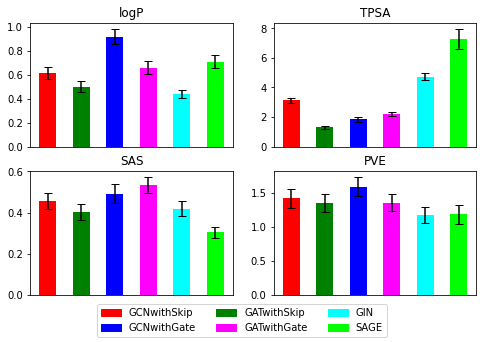

In [ ]:
title = 'One-hot feature training; MAE; Reproduce'
MAE_results = np.array([rearranged_results_GCNwithSkip[:,0],rearranged_results_GATwithSkip[:,0],rearranged_results_GCNwithGate[:,0],rearranged_results_GATwithGate[:,0],rearranged_results_GIN[:,0],rearranged_results_SAGE[:,0]])
std = np.array([0.1*rearranged_results_GCNwithSkip[:,1],0.1*rearranged_results_GATwithSkip[:,1],0.1*rearranged_results_GCNwithGate[:,1],0.1*rearranged_results_GATwithGate[:,1],0.1*rearranged_results_GIN[:,1],0.1*rearranged_results_SAGE[:,1]])
models = ['GCNwithSkip', 'GATwithSkip', 'GCNwithGate', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'PVE']
reproduce_result(MAE_results, std, models, tests,title)

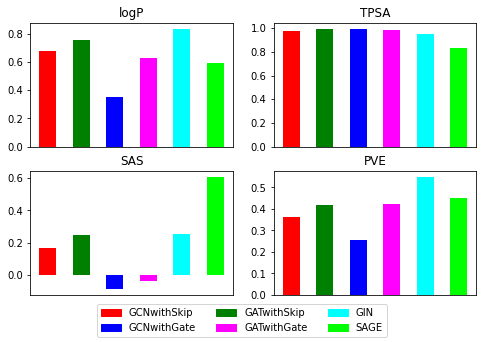

In [ ]:
title = 'One-hot feature training; R2; Reproduce'
R2_results = np.array([rearranged_results_GCNwithSkip[:,2],rearranged_results_GATwithSkip[:,2],rearranged_results_GCNwithGate[:,2],rearranged_results_GATwithGate[:,2],rearranged_results_GIN[:,2],rearranged_results_SAGE[:,2]])
std = None
models = ['GCNwithSkip', 'GATwithSkip', 'GCNwithGate', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'PVE']
reproduce_result(R2_results, std, models, tests,title)

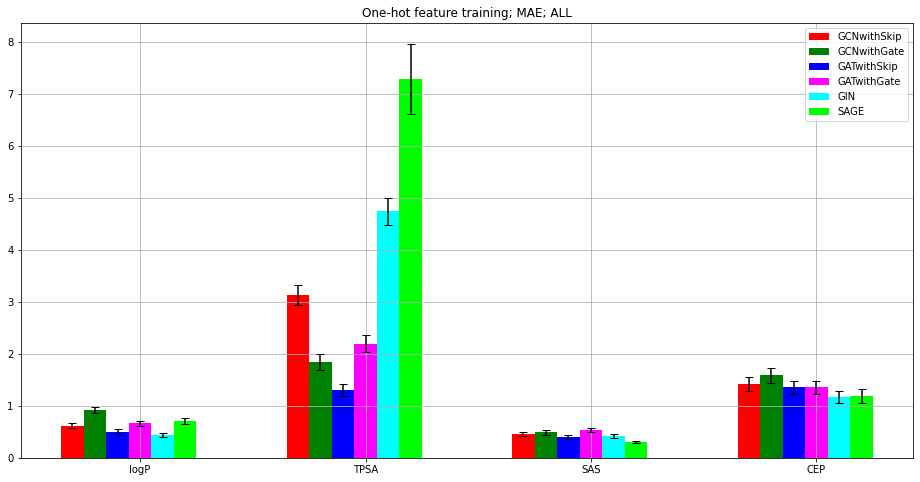

In [ ]:
title = 'One-hot feature training; MAE; ALL'
MAE_results = [rearranged_results_GCNwithSkip[:,0],rearranged_results_GCNwithGate[:,0],rearranged_results_GATwithSkip[:,0],rearranged_results_GATwithGate[:,0], rearranged_results_GIN[:,0], rearranged_results_SAGE[:,0]]
std = [0.1*rearranged_results_GCNwithSkip[:,1],0.1*rearranged_results_GCNwithGate[:,1],0.1*rearranged_results_GATwithSkip[:,1],0.1*rearranged_results_GATwithGate[:,1], 0.1*rearranged_results_GIN[:,1], 0.1*rearranged_results_SAGE[:,1]]
models = ['GCNwithSkip', 'GCNwithGate', 'GATwithSkip', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'CEP']
plot_result(MAE_results, std, models, tests,title)

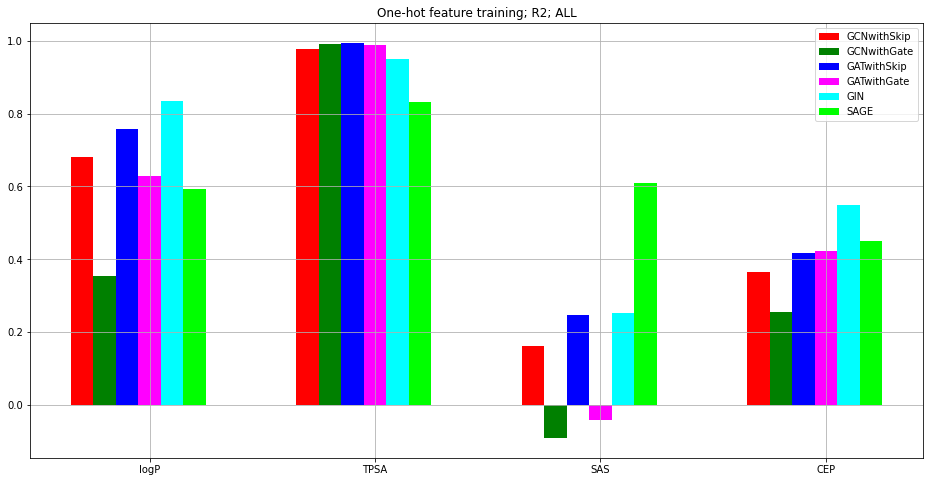

In [ ]:
title = 'One-hot feature training; R2; ALL'
R2_results = [rearranged_results_GCNwithSkip[:,2], rearranged_results_GCNwithGate[:,2], rearranged_results_GATwithSkip[:,2], rearranged_results_GATwithGate[:,2], rearranged_results_GIN[:,2], rearranged_results_SAGE[:,2]]
std = None
models = ['GCNwithSkip', 'GCNwithGate', 'GATwithSkip', 'GATwithGate','GIN','SAGE']
tests = ['logP', 'TPSA', 'SAS', 'CEP']
plot_result(R2_results, std, models, tests, title)

## All data logs

### one-hot encoding data

In [ ]:
results_onehot = [(0.6166293261260726, 0.5012465342240553, 0.6798086941231027),
(3.123841670513153, 1.9229357566476681, 0.9771581300121474),
(0.4566685426235199, 0.38176111535913365, 0.16288920496843073),
(1.416832413024269, 1.3559255965989536, 0.3640986319927292),
(0.9207081522531807, 0.6513143019226706, 0.3550771719023902),
(1.8465101370811463, 1.5876346498614624, 0.9899334283490606),
(0.4910830628871918, 0.46943875621386655, -0.09051539585772717),
(1.5879969605868682, 1.4079089362485044, 0.2553038686005694),
(0.5024369121082127, 0.4731668722585642, 0.7584774081333215),
(1.302907163143158, 1.2208238824025717, 0.9945883614881497),
(0.4033867183923721, 0.39476022216290974, 0.2473149338182543),
(1.3524516127770767, 1.3011506240314594, 0.41764171750160395),
(0.6622493265457451, 0.5415031596108765, 0.6289415084849104),
(2.198291628360748, 1.6069998796173266, 0.9874130418031823),
(0.5321858634948731, 0.3973172310672965, -0.042190133829330234),
(1.3542295647924767, 1.2845905687175299, 0.42392602661844103)	,
(0.6377413225211203, 0.5222964042393244, 0.655456282121466),
(1.124098154067993, 1.1312819732742745, 0.9956825494841673),
(0.5544393564462662, 0.5046569890875362, -0.32808626959072895),
(1.4477777724927292, 1.341352227272833, 0.3559409352270746)		,
(0.44019981639739125, 0.36192257208181355, 0.8353287762643447),
(4.742474989652633, 2.62750037766745, 0.9501018583305794),
(0.41891642987728117, 0.3759981971762482, 0.25131009233123947),
(1.1718845976060257, 1.1661928419236334, 0.5480642709963991)	,
(0.7094178589656949, 0.5473608267427135, 0.5929016051149278),
(7.294617097347975, 6.726925177500518, 0.8328577089297591),
(0.3040392483472824, 0.2704052964175001, 0.6088175504359759),
(1.1845211815899237, 1.386976218165898, 0.4499373519021631)		,
(0.9611904766596854, 0.6488376673667955, 0.31808102523745607),
(7.475469910621643, 7.356562931382846, 0.8132705869595729),
(0.4649470951557159, 0.3787029715588313, 0.15035683419538048),
(2.4246729697352274, 1.6352904055886737, -0.41421565433002105),
(0.5783649407112971, 0.48452285708223636, 0.7113529370958511),
(1.2891599507331848, 1.3596090571227453, 0.9940409264478243),
(0.5444022636413575, 0.4880095861472909, -0.2629805224435615),
(1.39887432283815, 1.3035664616837437, 0.3954829884808242)		,
(0.6933064909912646, 0.4693243913243881, 0.6445893332195729),
(1.3003703951835632, 1.1433548600380026, 0.9949104725243814),
(0.43859153127670286, 0.3653738400716999, 0.23005681814868828),
(0.9680725517021492, 1.1784938288419269, 0.6154097243057759)	,
(0.6557561563439667, 0.5633640831843615, 0.6210338819937448),
(7.013236223459244, 6.527711654216865, 0.8441741191719414),
(0.22791160953044892, 0.21407719471415568, 0.7689826082086237),
(1.1670366295343264, 1.3521065449198555, 0.4725276723042622)	,
(0.7133492502607405, 0.5646743950981828, 0.5803030804874107),
(8.216913103818893, 7.5597676144228565, 0.7883747074648098),
(0.492478654384613, 0.3268350826827191, 0.17454090317895632),
(1.2034623229866848, 1.3817704085722722, 0.4448418772739342)	,
(0.4056496858503669, 0.29560568446508095, 0.8722568813538096),
(1.0595642652511597, 0.7984518114094636, 0.9970120322744418),
(0.35920497024059295, 0.3559810555607837, 0.3957123364660483),
(1.0014784577032552, 1.1524229283594682, 0.614578785966754)		,
(1.1634218021677807, 0.5506778388997382, 0.15992279999816172),
(5.15723035812378, 2.0826692369785103, 0.9474881804237267),
(0.786770003080368, 0.43954282256780375, -0.9190773535805157),
(1.0523149112192913, 1.3149389225466135, 0.5310154389279327)	,
(0.6031340400166809, 0.49242609219825995, 0.6925993575998955),
(16.475450117111205, 6.284874093949317, 0.4721747139669381),
(0.4387141762971878, 0.4135323846571408, 0.14117164115296532),
(1.3982856069272385, 1.3767122940214198, 0.3633395300015122)		,
(0.8619173506684601, 0.6618188059991683, 0.40122278765467534),
(3.3523494334220887, 2.016031250502537, 0.9740235678436279),
(0.5019798038005829, 0.4141558660072344, -0.0006663658903045544),
(1.4472477162545547, 1.3967472683139597, 0.33111587730152336)				,
(0.818519263330847, 0.5322772468573658, 0.5166336651936647),
(19.426864014148713, 7.388446290058182, 0.266687060095286),
(0.7174379098415374, 0.5319466211043065, -0.8847681626412343),
(1.2761678795879707, 1.2712305507677328, 0.46352226089947357)				,
(0.7057185380645097, 0.5505942288950649, 0.593755939036023),
(18.356110238313676, 7.221598207165486, 0.3395001061025482),
(0.5163136212825775, 0.4035876808789388, -0.014734395552552959),
(1.5637031377768145, 1.3224889287406676, 0.3065267676857447)				,
(0.4287304610218853, 0.3686556986447177, 0.8378878504010042),
(2.171684292078018, 1.5385953874736873, 0.9879756766017848),
(0.39018597137928007, 0.4125799759004272, 0.2380743768063147),
(1.2451543973749504, 1.3271314173396667, 0.45243505710561416)				,
(0.664160362444818, 0.5620972733347357, 0.6161321846112416),
(2.2340779676437377, 1.287108179166386, 0.9887153457423686),
(0.5649435806274414, 0.4853897967037973, -0.3107972583426608),
(1.4543515986865387, 1.3787080888333199, 0.33598594806672044)				,
(0.6554500882662833, 0.5550829890633813, 0.6259336419015455),
(6.9158462345600125, 6.445311904302129, 0.848291486248892),
(0.3654159369468689, 0.3180907994328212, 0.4454260121019247),
(1.1799510878687725, 1.3123122553997495, 0.4850472236570732)				,
(0.7171937956996262, 0.55568723444434, 0.5826198297612467),
(7.582353868484497, 6.980630507708668, 0.819687829670965),
(0.4486981344223022, 0.333116759124903, 0.2621053176415794),
(2.945032733059488, 1.7139013524201352, -0.9197461667637647)				,
(0.7877177738882601, 0.572623764015033, 0.5191159677095016),
(7.769759588837624, 7.247826859372418, 0.8083503590372823),
(0.30697445273399354, 0.31480294772584844, 0.5431900360235644),
(1.2589368789857254, 1.4143973799845655, 0.40717157443865726)				,
(0.6266856428254396, 0.48866302440668563, 0.679785049186098),
(1.2145197114944457, 1.2061553477280655, 0.9950265055218974),
(0.4393252828121185, 0.42462080731183177, 0.11794444259220849),
(1.3566641901796683, 1.323257462560322, 0.4061619850488444)				,
(0.8598939149565995, 0.6727002635513583, 0.39562621323798064),
(1.1303736391067505, 1.1159181303345276, 0.9957171409659176),
(0.4982906937599182, 0.4182625766828502, -2.4614840924641612e-05),
(1.4804506654208527, 1.4102306636766901, 0.30878531801929165)			,
(0.5834383307509124, 0.4695869946259888, 0.7155899272318016),
(1.7327323794364928, 1.1984193690763978, 0.9924654628247437),
(0.3949400873184204, 0.4029752815318229, 0.24776322180312205),
(1.2455861051147803, 1.2866045872816259, 0.46977148301770166)			,
(0.6013292226828635, 0.5099600284395793, 0.6847898178776035),
(1.4813553624153137, 1.2697902119781301, 0.993537934733578),
(0.419361963391304, 0.3826012542387861, 0.23859219066070148),
(1.3779285342162475, 1.2390669215521468, 0.43221579884403494)			,
(1.0288141563124955, 0.7450866759753577, 0.18181903275738143),
(8.872064086429775, 7.630732466948956, 0.767539667670602),
(0.5078104181289673, 0.494021654470429, -0.18595712398188513),
(1.9694235147899017, 1.4492408704239634, 0.01142494921084658)			,
(1.3596434041447938, 0.837074588486393, -0.29263260628805177),
(6.2095076427459714, 6.875929103105471, 0.85429150099716),
(0.5438742067813873, 0.5383156707339042, -0.383614980461519),
(1.5821760587161406, 1.4146954106086613, 0.25518775370375824)			,
(0.7037530243992806, 0.5443512201440299, 0.5986266986668105),
(7.538430799722671, 6.898810185951473, 0.8227429677697811),
(0.23132261192798614, 0.2068886827101868, 0.7724315138512702),
(1.2360022011464462, 1.3613571223828955, 0.4409755530873385)			,
(0.8530029920777306, 0.6026200505566041, 0.44692851360951313),
(7.679449636697769, 7.167308099799209, 0.8126890464232809),
(0.30616436958312987, 0.24278630647559352, 0.639243500856949),
(1.630080519146286, 1.2738024734853126, 0.2923749165064652)				,
(0.6490579059834126, 0.4905710647277326, 0.6643658423252692),
(1.3883486490249635, 1.332227833552025, 0.9937152196042764),
(0.4383340837955475, 0.4122856390043389, 0.14439200564739896),
(1.3249854261940346, 1.3233792314625845, 0.4201548251222317)			,
(0.8883090430684387, 0.6498228446638491, 0.3857795742652188),
(2.4193639183044433, 1.614441489033133, 0.9856394645403878),
(0.48810287690162657, 0.4443226652558152, -0.029393859227295538),
(1.452034369654022, 1.3972562613970283, 0.3285861286334516)				,
(0.5687925960309803, 0.47722360084675014, 0.7204803396666959),
(1.322353308200836, 1.1949119590826915, 0.9946079595732419),
(0.41416147029399875, 0.40596771372601825, 0.2052971993792546),
(1.4228386241262778, 1.190526022565057, 0.43091817237882957)			,
(0.6704624641127884, 0.5475356812601644, 0.620060341921445),
(4.289552829742432, 1.8574292332628934, 0.9629087901661358),
(0.4864574534893036, 0.44906633070654767, -0.035618356940742446),
(1.406535319126211, 1.274669041530952, 0.40424818187774847)				,
(1.0875051242299378, 0.7658584427608531, 0.10292531448257547),
(6.155202285170555, 5.202774124580224, 0.8897373196548339),
(0.5037205077409744, 0.49209427258772015, -0.17169126679538427),
(1.4752501040166244, 1.3313529425498247, 0.34708230156994613)			,
(0.7530353995151817, 0.6096430313785514, 0.5240192992378037),
(4.305411000043153, 3.9595342538709866, 0.9419204363823965),
(0.3556342668533325, 0.3535842627568066, 0.4057617003680146),
(1.2949329115813597, 1.2898748610029767, 0.44764983824709437)			,
(0.5767072738744319, 0.4665954442411673, 0.7209695377394045),
(5.739691759228706, 4.484830096615929, 0.9099336857602917),
(0.3069640529155731, 0.294931696054494, 0.5718332503850034),
(1.282529710895382, 1.3055193811883787, 0.44622211443049076)			,
(1.535464668240398, 0.7917389441834434, -0.513289370124403),
(10.90230311536789, 7.754403615722468, 0.6961602247290701),
(0.3347475205659866, 0.3247428781714122, 0.48605842240127883),
(1.6735426872735844, 1.3073784735880685, 0.2543049179924045)			,
(0.6692065628943965, 0.5113108989470952, 0.6403620722958738),
(1.2068647675514221, 1.1153552430007938, 0.9954157947391112),
(0.549813999414444, 0.5290995471913322, -0.3757205146088607),
(1.4213943541711196, 1.3147144426975654, 0.38015549526535164)			,
(0.6664363298276439, 0.43708749341912495, 0.677931068434346),
(0.5634688186645508, 0.6284684419363343, 0.9987905724597254),
(0.8727953306436539, 0.4782939537492832, -1.340439783427735),
(1.1381592312594875, 1.1618686957998348, 0.5626101651028736)			,
(0.2902615184448659, 0.25991999674002186, 0.9230247898375775),
(1.0357052583694457, 0.9157101133454971, 0.9967556928930267),
(0.3373753399848938, 0.3447638760571427, 0.45021378425207714),
(0.9390077763712034, 1.1005026285651214, 0.6539628839722944)			,
(0.40065408300235866, 0.3442714601016812, 0.8585096915802303),
(0.9680166325569153, 0.8368208985614936, 0.9972206165766291),
(0.5838499726057053, 0.44149697362950485, -0.2659888089313853),
(3.7919618370095267, 2.368068400640569, -2.3046684900153402)			,
(0.8370115878768265, 0.6332768132921325, 0.4414204940787463),
(1.3688198280334474, 1.0507607628192661, 0.9949451995915385),
(0.5764946378469468, 0.5043319688562006, -0.38624687467803875),
(1.5152017700141296, 1.3950323725613438, 0.29862216363024485)			,
(0.40229431450739506, 0.358969266254614, 0.8526009883877121),
(2.7291635279655457, 1.7649657405800676, 0.9820684128344181),
(0.4383396462202072, 0.3581776055113218, 0.2428814597434409),
(1.143249380535446, 1.2706392466245597, 0.5169427163486852)				,
(0.42775328869745133, 0.3690044203831824, 0.8381817838031222),
(1.5707482221126556, 1.2447101069302613, 0.9931818431799384),
(0.33672879815101625, 0.33583983477607343, 0.46559459763932387),
(0.9140331767918543, 1.0976731052925546, 0.6626431940552755)			,
(0.4272633010763675, 0.3652667430420459, 0.8397857913309559),
(1.0628463351726531, 0.9317002214738588, 0.9966088625835203),
(0.42071495139598847, 0.3606025778247078, 0.27453719062235915),
(3.4275308517413214, 1.8283051009361173, -1.4951390905031152)			,
(0.39763545168563724, 0.3340891702234927, 0.8632338717843857),
(1.9328954093456268, 1.1318835005556593, 0.9914831546485843),
(0.3252820420265198, 0.32545214176008497, 0.4997303738664275),
(1.1676717061279343, 1.355090155851033, 0.47094700126662714)			,
(0.4835040294714272, 0.3146616340712435, 0.8312600800197892),
(1.827279061794281, 1.0416575378457769, 0.9924901977939836),
(0.3544935907125473, 0.36749661038929854, 0.3839721958023642),
(1.081137485026382, 1.3005413293204708, 0.5270744891833858)				,
(0.4565179513115436, 0.3247268846010197, 0.8408594844291037),
(3.534005594730377, 1.904828108683585, 0.9726402006768972),
(0.37451362812519073, 0.3206356675124405, 0.42567980120130156),
(0.9800019397838041, 1.1790027936613816, 0.6113688657614267)			,
(0.22792366071231662, 0.25244989113120614, 0.9413444814521341),
(1.4755249485969544, 1.1690258579099366, 0.9939843565037279),
(0.3978213991522789, 0.37058830639907814, 0.3015622549978322),
(0.9780268449587748, 1.1680411996887239, 0.6162621372982476)			,
(0.24731687924452125, 0.25853868565352284, 0.9350937072012371),
(1.3697424206733704, 1.162502502168962, 0.9945210918133776),
(0.35668485164642333, 0.3691744236193825, 0.37736965061602923),
(1.1788168384348974, 1.097770672020168, 0.5709824358349616)				,
(0.4298542194608599, 0.30975651037150975, 0.8576592620251643),
(1.939924317598343, 1.1689500307871479, 0.9912921747586307),
(0.35091152346134186, 0.3496062182799714, 0.42025548419432757),
(0.9387004846679047, 1.1154190985544585, 0.6485930784831794)			,
(0.12464242765679956, 0.1471572083517392, 0.9811423456649867),
(1.238915887594223, 0.9501534404170672, 0.9958619621988255),
(0.1991140971183777, 0.20893092192223472, 0.8031822238821945),
(0.5519524944731966, 1.0952085564907206, 0.7513017933657266)			,
(0.14780820667184888, 0.17052488032830787, 0.9741780143551507),
(0.7896777012348175, 0.6951762990000119, 0.9981210876177629),
(0.15574327182769776, 0.18122864180936027, 0.865084654584547),
(0.6924253470310942, 1.0375558842201733, 0.7427301153270527)			,
(0.14780820667184888, 0.17052488032830787, 0.9741780143551507),
(0.7896777012348175, 0.6951762990000119, 0.9981210876177629),
(0.15574327182769776, 0.18122864180936027, 0.865084654584547),
(0.6924253470310942, 1.0375558842201733, 0.7427301153270527)			,
(0.13740649434179067, 0.16388383795412262, 0.9768083540240141),
(0.8005697538852692, 0.7033694784442157, 0.9980722338408097),
(0.11289720273017884, 0.14542468335146158, 0.9199149996094327),
(0.6717600103477016, 1.0354500102892927, 0.7481131669567793),
(0.21302249807864426, 0.22302086352813402, 0.9517710611942006),
(1.0519755316972732, 0.9240980876502304, 0.9966718366999944),
(0.1588117835521698, 0.17930275206515786, 0.8644446379935952),
(0.7448902541464195, 1.1544071871002952, 0.6879118417047465)	,
(0.15274790924042464, 0.1582847648767977, 0.9754659243806464),
(0.6415387034416199, 0.6295980451525593, 0.9986284667728671),
(0.13573186850547792, 0.14635294176320446, 0.9058605799761215),
(0.6769825383191929, 1.0736331937194132, 0.7336331780089724)	,
(0.4894786796085536, 0.4100893070995265, 0.7932443094181785),
(1.0872315430641175, 0.9157093571001762, 0.9965700091616219),
(0.3220373919010162, 0.311176253884817, 0.5261671713055576),
(1.042938894010149, 1.205127080796882, 0.580019560528298),
(0.3351621585525572, 0.3108138762377694, 0.8940576880002898),
(1.1270003213882447, 0.9082864943739775, 0.9964435137427841),
(0.30083073699474333, 0.3041583673489485, 0.5675806612045748),
(1.0059160861140117, 1.1331837315252706, 0.6203765723178003)	,
(0.20286606867052615, 0.2177722956240999, 0.9550858827206199),
(0.8759015702009201, 0.9574917759562819, 0.9971413958819325),
(0.16909676551818847, 0.19378328924052032, 0.8437110261315184),
(0.9029566035112366, 1.2039336682624464, 0.6255329049525142)	,
(0.19142407316341997, 0.20381182559783462, 0.9603576618906166),
(0.9228797669410705, 0.9144322191162144, 0.9971347767881156),
(0.1407491408586502, 0.17052714560595736, 0.8844831417823644),
(0.5551445825481788, 1.2288398707439905, 0.6993675635271299)	,
(0.13066546807251872, 0.16748378491659202, 0.9771197705701401),
(2.1869656171798706, 1.1572661104749684, 0.9896076753527434),
(0.1399798356294632, 0.16309380310370153, 0.8908529774569163),
(0.6303713748240843, 1.0830067418076752, 0.7403662700358403)	,
(0.1066107285618782, 0.13774201215957785, 0.9846167830640716),
(0.949083438873291, 0.7983785654349582, 0.9973889382133394),
(0.2530765670537949, 0.20063872927257181, 0.7535513980030563),
(0.6030412612417713, 1.1490473241879042, 0.7215672711511647)	,
(0.12323844731971621, 0.1657418648500301, 0.978370256257749),
(0.978288605928421, 0.7400543824026312, 0.9974457007551709),
(0.1306979726552963, 0.1681130146217781, 0.8928613504868175),
(0.6990607809880749, 1.1147465925595923, 0.7137337364700522)	,
(0.1848523431904614, 0.1378218197215467, 0.9730426085898559),
(0.7513547229766846, 0.7080303121642135, 0.9981907198538374),
(0.13729850316047668, 0.17280661340254697, 0.884900940095672),
(0.4589643161157146, 1.1368422016127409, 0.7514795213460175)	,
(0.11522856808826328, 0.1452152430306156, 0.9825752103090019),
(0.8400478529930114, 0.6964776446285655, 0.9979786652348578),
(0.11728882586956024, 0.15192893820703574, 0.9129566638909948),
(0.4031303146937862, 0.8985732667087499, 0.8396257076505584)	,
(0.0936551477201283, 0.12388971139934359, 0.9877700011167859),
(0.8029380917549134, 0.60191177069636, 0.9982905905379829),
(0.14159975039958955, 0.153240665764186, 0.8971398008735804),
(0.4223557016318664, 1.0634435157593136, 0.7835167463282149)	,
(0.13462895296886562, 0.14092578759654742, 0.9807397213339912),
(2.7234206156730654, 1.606935196934639, 0.9830261114851139),
(0.1719526574611664, 0.14609996787880317, 0.8797029882746668),
(0.4340408763596788, 1.0431467978436786, 0.7889316904982656)	,
(0.3031094070933759, 0.16476623508802524, 0.9396493744236023),
(1.2589876341819763, 1.0506357521169933, 0.9954355784858503),
(0.15346203196048736, 0.1463021026547089, 0.8937805863772922),
(0.5468562210509553, 1.011286987287788, 0.7814571245165702)		,
(0.11861667182855308, 0.1657047815491649, 0.97894326804437),
(1.5339581899642944, 1.2330032261479342, 0.9934249756903523),
(0.1632155624628067, 0.15598721781550876, 0.8795649655115345),
(0.5981374452123418, 1.0104485566643366, 0.7720289925312637)]

### atomic features data

In [ ]:
results_atomic = [
    (0.5981053461059928, 0.4641244042090574, 0.7093891032968702),
(1.9359468603134156, 1.856128530376922, 0.987789603672084),
(0.43235601687431335, 0.3400324436535093, 0.2851260796057631),
(1.281180002993904, 1.296096664098096, 0.450847516012182)				,
(0.7339701287634671, 0.5479043846297087, 0.5746307016731977),
(1.31890185546875, 1.111809582830533, 0.9949488377883035),
(0.48806800866127015, 0.4457698639962661, -0.03235705409776268),
(1.1833984898282215, 1.3051403398083796, 0.48680395093887807)		,
(0.4693479094281793, 0.39950820312875857, 0.8073749343201799),
(3.0080156474113466, 2.513380666224637, 0.973917283444562),
(0.3856357449293137, 0.3253970903315206, 0.39843552992254183),
(1.0348401510948315, 1.1807055918446463, 0.5924356742590393)		,
(0.4891029637083411, 0.3972136199377221, 0.7987012984821922),
(1.3827787036895751, 1.1308426234804383, 0.9945834319830744),
(0.42182302069664, 0.36087280874326255, 0.271870640515142),
(1.0204894710769876, 1.1730715102335416, 0.6002835738037162)		,
(0.5544244090477005, 0.4669500058140275, 0.7335818049168954),
(1.2581334300041198, 0.8887962200966002, 0.9959720386865518),
(0.5142470117807388, 0.4709663789805746, -0.14893324624452542),
(1.1351617729505523, 1.2227535928748474, 0.5397310824442632)		,
(0.29233353482186797, 0.2785901016004198, 0.917314814743478),
(1.534736140727997, 1.2983649619819608, 0.9931400616330647),
(0.37047531580924986, 0.3517207275442152, 0.38340520591623983),
(1.102978527805768, 1.2393668817235335, 0.5448776702550442)			,
(0.5569005048051476, 0.44158983623869247, 0.7438693138371841),
(7.891296156987548, 7.067688369958957, 0.8094968336248664),
(0.24045473992824554, 0.2170960422207261, 0.7520261518343874),
(1.208341886616312, 1.3052824167844999, 0.4768785628094926)			,
(1.0488957144035957, 0.7826951159721292, 0.13152931888729635),
(7.582744015350938, 7.036221770324004, 0.8183550582933117),
(0.5264147367477418, 0.3797914828207622, 0.004424898133677746),
(1.771351094729267, 1.4003565285892519, 0.1569674623898809)			,
(0.5215831180512905, 0.4224461405413188, 0.7715694421324603),
(1.2489122359752656, 1.0342759408642328, 0.9955363715447144),
(0.5197630523443222, 0.45065440766019704, -0.11817835520823117),
(1.0947619820805266, 1.2181456090909797, 0.55648631288099)			,
(0.26593921006971505, 0.27098267247113855, 0.9269061910637858),
(0.8753932616710662, 0.9215878914997647, 0.9972574319505668),
(0.3500349180698395, 0.32152900380065286, 0.4662309798004146),
(1.0309807308996097, 1.209497223010178, 0.5823753732234009)			,
(0.5157648554295301, 0.42506800370192127, 0.7735030724751746),
(7.69567065737769, 6.941479221270426, 0.8176742582004153),
(0.2558271653652191, 0.22653953420416598, 0.7241013462023524),
(1.1430123748248442, 1.328493087642444, 0.49216968793305527)		,
(1.014059711176902, 0.8257186997843657, 0.13288080529842994),
(9.472491007328033, 7.840197736211427, 0.7433412824028658),
(0.4985147266387939, 0.38010589204267414, 0.0714259125497212),
(2.2450045399134977, 1.446704350705278, -0.1793927970348157)		,
(0.28031667590886356, 0.2869575128071008, 0.9184046090736018),
(3.7783890833854676, 1.5470144343758025, 0.9717033220270119),
(0.38304056894779204, 0.35587491354527534, 0.35408853149248243),
(1.006751406623982, 1.1988428693806674, 0.594781433290061)			,
(1.683687994947657, 0.6495063082574284, -0.6512885808091944),
(1.328507904291153, 0.7885916987817246, 0.995948355525229),
(0.5399313579797744, 0.43238494970724584, -0.13055845631256457),
(1.2008080060100184, 1.2286647654308698, 0.5119801501184131)		,
(0.7074097545221448, 0.4756832624734211, 0.6315257937145436),
(20.63734667682648, 7.68206342810427, 0.17685121758325872),
(0.4204660782814026, 0.3724431549472854, 0.2545234826692844),
(1.2245095866983757, 1.3368421834657949, 0.4565879028116002)		,
(0.7192635775692761, 0.5522537842987297, 0.5830411403642313),
(16.21081060934067, 6.085365408715695, 0.49104775710021975),
(0.4881313934326172, 0.4446279146105505, -0.030100786149776182),
(1.2653565228348598, 1.3577866315469425, 0.4304403791698471)		,
(1.220338793631643, 0.5673463404650778, 0.08167889430081698),
(19.49193978780508, 7.478042612769041, 0.2601267543890946),
(0.5210536826848984, 0.44289722859476044, -0.10497472386477025),
(1.0525124509995802, 1.2239941496108853, 0.5691248793395767)		,
(0.4474987426288426, 0.3932397385803654, 0.8200519987035113),
(18.270501089572907, 7.2451877403189435, 0.34424348457844245),
(0.4395951417684555, 0.39502278426550674, 0.17470513555870482),
(1.006789695600979, 1.225993318299321, 0.5838832522494384)		,
(0.588096890093293, 0.4540591729135934, 0.7200948291094775),
(1.50290625, 1.2981433313877784, 0.9933051674672457),
(0.511853178024292, 0.46451609389589543, -0.12887203486289422),
(1.1639177016159519, 1.2765490797943022, 0.5065692948126199)		,
(0.2787540530823171, 0.27723819909175085, 0.9216280279450909),
(1.6418733642101289, 1.3203459457094404, 0.9924646292135817),
(0.47877236938476564, 0.33711965809931643, 0.18986070576776282),
(1.0959625945603475, 1.462153935195459, 0.44791443094807626)		,
(0.5596616149581969, 0.4510082317708209, 0.7380434241802583),
(7.7020267052650455, 6.903411151520568, 0.8184027969941985),
(0.2804202629327774, 0.23931687137127253, 0.6788764442003455),
(1.1552744257217273, 1.360000753349202, 0.47350411572359863)		,
(1.003433338779956, 0.8352468560113296, 0.1357267166178967),
(6.990345459669828, 6.5558958968340555, 0.8440923008652437),
(0.6027285656929016, 0.3768494568741146, -0.19391602770604766),
(1.5046095414822922, 1.2663152475905672, 0.36055105021954825)		,
(0.6033238150794059, 0.46585073480323197, 0.7053960580749032),
(7.977924434900284, 6.788022645271614, 0.8137410340996027),
(0.22987148416042327, 0.19274680295235844, 0.7873664112391667),
(1.1639353905385361, 1.3514838498844444, 0.4740012792201882)		,

(0.8502642924971878, 0.6401836787604704, 0.4256225718839628),
(7.676360390596091, 7.110868610279079, 0.8141375199553305),
(0.4775405993461609, 0.45630767862339, -0.030798950591418794),
(1.6343023130362853, 1.434228358693274, 0.21826482511306144)				,
(1.0160568274445831, 0.7014969646560679, 0.22701904481843138),
(6.881624356269836, 6.495031834915419, 0.8480008418556042),
(0.5726946604251861, 0.5489635238099195, -0.48700449258652423),
(3.8324068850940094, 1.9170822460065018, -2.036122104031683)				,
(0.5580928360037506, 0.45961996197664284, 0.7349562175435959),
(7.843605670526624, 6.7221980703103155, 0.8188580772813743),
(0.24129513490200044, 0.21697872942794796, 0.7511898681546523),
(1.2260089650219306, 1.2995979581200514, 0.4722157967558742)				,
(0.7870811826747377, 0.5788313630355306, 0.5160000144906538),
(8.261812701582908, 7.507035229665161, 0.7884674261823091),
(0.5101911289691925, 0.3809186013535552, 0.042135358041597515),
(1.4473502996629104, 1.2791741972010258, 0.38308644460179564)				,
(0.6149871715581976, 0.4799098070597232, 0.6914491076740081),
(2.027413493156433, 2.1642122249840186, 0.9850716851347213),
(0.4161769287586212, 0.3484490282261806, 0.3038721210191888),
(2.024253836340271, 1.7690014834513665, -0.1949302587466326)				,
(0.7391488007195294, 0.54630932634926, 0.5716474956937942),
(1.1104349088668823, 0.8015747967158295, 0.9968161626875008),
(0.5104659795761108, 0.40739695147238825, -0.007846884087646),
(1.1765587051240727, 1.2990104933397708, 0.4921122352259715)				,
(0.5116731725484133, 0.3971738612785073, 0.7872642254344504),
(3.3876592154502867, 2.730904655301263, 0.9678591352790363),
(0.377649956703186, 0.323777048024978, 0.4153227588517644),
(1.0618851663181559, 1.1652774765613476, 0.5890441760609983)				,
(0.5105546113736927, 0.46231025351750693, 0.7594575128277199),
(1.3869838047027587, 1.2813965387985895, 0.9939471710361444),
(0.3960183527469635, 0.32904623750878276, 0.37361723287189774),
(1.0539937336528673, 1.1648895176803904, 0.5919544352860759)				,
(1.0355593761391937, 0.759366942705836, 0.16386510556910538),
(7.137852935552597, 5.340024238951419, 0.8651073543472326),
(0.5001467196941376, 0.4806332939056802, -0.13687301032695087),
(1.3273039912646636, 1.2982283081855268, 0.430040090129699)				,
(0.8682146619297564, 0.6347149583935386, 0.41351663745013956),
(4.275034356594086, 4.3429848974603305, 0.9369586677728762),
(0.5325304012298584, 0.4804990396787611, -0.215584595792909),
(1.2393614297276363, 1.2792341785428474, 0.4754558616086959)			,
(0.5586846806146204, 0.4324114070617289, 0.7469276104312195),
(4.057771604299545, 4.180082492876488, 0.9423887387480768),
(0.3064065968990326, 0.2765810269518368, 0.597421347632553),
(1.0813137245615945, 1.2396746353668133, 0.5525759381111794)			,
(1.4811427499838172, 0.8808247479808924, -0.5057514655015278),
(8.741815585494042, 7.089197191288013, 0.7849655737256851),
(1.2747879258394241, 0.6296536712538109, -3.776512481984648),
(1.4666431734031067, 1.335063375646344, 0.34963306949649275)			,
(0.5616920662634075, 0.4691601229615212, 0.7284198087423353),
(1.1071562855243682, 0.8542290367193568, 0.9966805067667539),
(0.5253118659853935, 0.5006929206253409, -0.24435877193976707),
(1.1170145339397715, 1.2176121288189339, 0.548563357664134)				,
(1.348909629913047, 0.5425055533842301, -0.07183572551656514),
(5.9367700755596164, 3.110931133470019, 0.923742338840772),
(0.3729990050792694, 0.3579682438146629, 0.3684957251207557),
(1.5247984302183613, 1.3085236057100733, 0.33246914588947585)			,
(0.24197270524129272, 0.2504190836890995, 0.9385149621399647),
(4.9469266705513, 2.396031476767824, 0.9487129129297921),
(0.336846984744072, 0.3401720320469805, 0.45848676673780764),
(0.9627478064084426, 1.1387856088723778, 0.6323236992457193)			,
(0.6447842908538878, 0.5031995747306895, 0.6608061245876315),
(1.8510026717185974, 1.339522940014822, 0.9911380708987085),
(0.56137233877182, 0.41301766070010276, -0.14766482824402116),
(2.4152450098739937, 1.4848367639618487, -0.32905315554664827)		,
(0.6412017735755071, 0.49017175407364433, 0.6697040923032895),
(0.992556009054184, 0.9422558913825694, 0.9968205325064071),
(0.5201133400201797, 0.4588742388988446, -0.13670371376367552),
(1.3082594343489036, 1.3441764057953574, 0.4182642931261661)			,
(0.5243699912428856, 0.3127684542359929, 0.8109781629077144),
(0.9824093501567841, 1.012544906553584, 0.9966213092949894),
(0.3963387188911438, 0.3235542608069278, 0.3814858803747331),
(1.009250197536312, 1.2280964242455854, 0.5822097012442591)				,
(0.2612594122961164, 0.2592642430790973, 0.9313078056659546),
(1.1862075147628783, 1.0093499389425882, 0.9958820413656024),
(0.350289562702179, 0.3321135318726728, 0.44946258999519406),
(0.9555022064363584, 1.1427476412463307, 0.6331271619387535)			,
(1.1384233822207899, 0.62306852937845, 0.1460165624298716),
(1.1476132416725158, 1.030447415508323, 0.9959618882635132),
(0.5669219696521759, 0.4691237170892551, -0.2794029255012933),
(2.222033871771768, 1.4886781525847246, -0.18279858680484518)			,
(0.3901668152995408, 0.2812644200177312, 0.8826993409634813),
(6.874843416690826, 2.340847715195423, 0.9104679316530053),
(0.3126886613368988, 0.31456858247600894, 0.5351721561664728),
(1.142305107540451, 1.3556242333666764, 0.4803961204453856)				,
(0.6253740211185068, 0.3411246000427946, 0.7426935158674695),
(2.8162633669376373, 1.3411169074949485, 0.9834832973699115),
(0.336317641377449, 0.3357466174594176, 0.4663963689469208),
(1.1974304355261847, 1.3211123420099167, 0.47434465101581613)			,
(0.5005579461194575, 0.4090639756882396, 0.7881084206784907),
(1.1028845868110657, 0.925711095740622, 0.9964805511903567),
(0.3429584988355637, 0.3170368358131816, 0.48459573675421197),
(0.9759964558416978, 1.1783463843890782, 0.6129201331144303)			,
(0.25802880761399866, 0.25491231617475935, 0.9332930419147059),
(0.9343377754688263, 0.8299131685136077, 0.9973489189076419),
(0.354691841006279, 0.3630557823874866, 0.3913055249835258),
(0.955750607422553, 1.1443701587350643, 0.6324350939179864)				,
(0.2564095681179315, 0.23656234693751677, 0.9382882589145906),
(1.1619275560379028, 0.9338368070137797, 0.9962279077790475),
(0.3459780937433243, 0.32281979450932996, 0.47093740001262685),
(0.9505860883379355, 1.2016591849169527, 0.6118405372092262)			,
(0.37098570858500896, 0.3034148783210367, 0.8835353805290315),
(1.4967475666999817, 1.1028843009577385, 0.9941323598460555),
(0.3544587744474411, 0.348816268020242, 0.41564706490595626),
(1.0188933829208835, 1.235051577699462, 0.5761433691921467)				,
(0.09714177322015166, 0.09271037214563317, 0.9908570228903717),
(0.6376768517494201, 0.6768647228415507, 0.998532027563057),
(0.11817277932167053, 0.14106526570413272, 0.9199856519233621),
(0.4894616598794237, 1.2240460487498799, 0.71265644210988)				,
(0.14987414429336787, 0.14007527490007746, 0.978661677129028),
(3.249994821071625, 1.516512921833885, 0.9781660986441977),
(0.16217938208580018, 0.15894411443621373, 0.87816134087669),
(0.5852240705499425, 1.1631985583151883, 0.7196576262646666)			,
(0.14987414429336787, 0.14007527490007746, 0.978661677129028),
(3.249994821071625, 1.516512921833885, 0.9781660986441977),
(0.16217938208580018, 0.15894411443621373, 0.87816134087669),
(0.5852240705499425, 1.1631985583151883, 0.7196576262646666)			,
(0.06878577795624732, 0.08720607483590541, 0.9937448475605202),
(1.0355485272407532, 0.8374057727962856, 0.9969892729299024),
(0.11939005517959594, 0.1374083879094195, 0.9217085216709123),
(0.40137044164631513, 1.0378565972931433, 0.7952646945582815)			,
(0.051922077023889866, 0.06084939173405876, 0.9967556203485902),
(0.5200317816734314, 0.4904942798258857, 0.9991325401238734),
(0.131257980465889, 0.14318929400554073, 0.910847250083691),
(0.46753094241116194, 1.2385152572394398, 0.7102351930244648)			,
(0.15185967509075998, 0.14741141010185557, 0.9772885155196613),
(1.3277314767837525, 1.2555031393777494, 0.9943317296025023),
(0.18055610632896424, 0.15800633623931418, 0.8639818829409046),
(0.5869583874056116, 1.064503158376975, 0.755674495060795)				,
(0.08703570326045156, 0.07857048801664444, 0.9930288168331505),
(0.33806419229507445, 0.3988153422866156, 0.999535999596782),
(0.10126879143714905, 0.12203511876921672, 0.9405804654426753),
(0.4373962963381782, 1.1400468942691342, 0.7534695909495673)			,
(0.4316614078767598, 0.34164122941833397, 0.8463386011929515),
(2.795802885532379, 2.4396780129279523, 0.976627701119402),
(0.3728917555809021, 0.3607823127610266, 0.3639057102651768),
(1.1644334118971602, 1.146464819394936, 0.5584862660146153)				,
(0.2753182970173657, 0.2556792090287769, 0.928418845267038),
(0.7813734529018402, 0.8135253001448006, 0.997840137228609),
(0.24078676056861878, 0.22445779008499162, 0.7439680840391429),
(2.114444253391586, 1.8900447685691373, -0.32987905380979354)			,
(0.12840938356332482, 0.12912863272077763, 0.9831846408701613),
(0.48653982400894163, 0.5727430631459488, 0.99904131922529),
(0.15742532932758332, 0.13328222181326785, 0.8994702441164304),
(0.6731928016850725, 1.1009744391886476, 0.7246484831909445)			,
(0.09724166739545763, 0.09808188420744704, 0.9903275313953565),
(1.3045039701461791, 0.7633224755962323, 0.996122212076932),
(0.11579527997970582, 0.1453234863597508, 0.918418530884461),
(0.5231796650299803, 1.1795744064995861, 0.7246849449390007)			,
(0.26574617928639055, 0.1738480260803292, 0.9488670498669026),
(2.0529836053848265, 1.2000882086725517, 0.9904006353566769),
(0.15051543867588044, 0.14811255961101272, 0.8946375097023166),
(0.5296196431228891, 1.0791837649410996, 0.7610568388671806)			,
(0.11196724219620227, 0.09651751860775815, 0.9889198124315199),
(0.474104896068573, 0.4725492671555519, 0.9992393807109284),
(0.12430752658843994, 0.13867825060961161, 0.9180486209155767),
(0.5358837838331237, 1.2400381791106314, 0.6982708123818657)			,
(0.12314798886701464, 0.11898727209766315, 0.9851315957878709),
(0.6016713922023773, 0.613868513962125, 0.9987458033623926),
(0.13138487482070924, 0.14553071938846754, 0.9091712118563547),
(0.6491415623733774, 1.0951655491682908, 0.7320163272431083)			,
(0.10881697027012706, 0.10105971359283997, 0.988817437175425),
(0.9229322209358215, 0.942639819426154, 0.9970456906126708),
(0.1381124747991562, 0.16651975347408343, 0.8894118092083793),
(0.4901832892308012, 1.1980164799513118, 0.722963656028165)				,
(0.14180753750354053, 0.10552270604843243, 0.9841575436621897),
(0.5931621942520141, 0.52249950670596, 0.9989393130295673),
(0.16111354541778564, 0.12869313825617587, 0.8995349531927561),
(0.44050293881539254, 1.0728726867266452, 0.7775970977854917)			,
(0.09801700142398477, 0.08370764487390148, 0.9915757320224394),
(0.3357264723777771, 0.4037283134983786, 0.9995319803240742),
(0.11224241375923157, 0.13470632282784292, 0.9273577329102782),
(0.43971104024443775, 1.0884903716628207, 0.7721311086375809)			,
(0.09956528959050774, 0.09840228236928862, 0.9900637349253504),
(1.2608357276916504, 0.9257753526110136, 0.9958465783070415),
(0.1209929860830307, 0.12558184871143935, 0.9281470247611642),
(0.4586252380916849, 1.0807077386534205, 0.7721130469963234)			,
(0.10024649142101406, 0.08489448899073711, 0.9912501400798207),
(0.7742684254646302, 0.7043612122092895, 0.9981401755669177),
(0.09836056876182556, 0.11016206965848026, 0.9484662028400555),
(0.43769648382719606, 1.0621786203953607, 0.7817797857330289)			,
(0.12314798886701464, 0.11898727209766315, 0.9851315957878709),
(0.6016713922023773, 0.613868513962125, 0.9987458033623926),
(0.13138487482070924, 0.14553071938846754, 0.9091712118563547),
(0.6491415623733774, 1.0951655491682908, 0.7320163272431083)
]

### atomic and molecular features data

In [ ]:
results_molecular =[
    (0.6679110404867679, 0.45586477230987676, 0.6684315075808459),
(3.3915656542778017, 2.379612087582881, 0.9708617053531711),
(0.41667067778110506, 0.3510106358048723, 0.29866697104405937),
(1.0705241028955206, 1.2091904333896952, 0.5687579462087037)			,
(0.6608753828927875, 0.5462337086091176, 0.6272542041788564),
(0.965086021900177, 0.9755053205494876, 0.9968035776240173),
(0.44221795606613157, 0.3994604684982675, 0.16090993622679073),
(1.1762880389308557, 1.2517983416440708, 0.5121296756599978)			,
(0.5093509485386312, 0.4284534322435164, 0.7753717826079523),
(2.9666005518436434, 2.6291000244304055, 0.9733271506129979),
(0.4000424702167511, 0.371145043082867, 0.29639939050627073),
(1.03949447130505, 1.2088548331686926, 0.5797176527825133)			,
(0.42089955614320934, 0.38408784067339413, 0.8353713282471738),
(2.495401593208313, 1.9645770420658168, 0.9828778650283336),
(0.37577698814868926, 0.3313618021665991, 0.40691610243909326),
(1.0097332293689252, 1.1568773879098286, 0.610132909580244)			,
(0.5585560286883264, 0.47596915768673104, 0.7269380701664387),
(1.2609328269958495, 0.9282112493680764, 0.9958384964718131),
(0.5378029689788818, 0.44296747369000933, -0.14702622357454276),
(1.113685166333802, 1.2210305388636498, 0.5484129844351995)			,
(0.34793484353646636, 0.31559148177012086, 0.8881162378535989),
(1.2951333904266358, 1.1406299977019376, 0.9949441108255851),
(0.4423052282333374, 0.3244014599435557, 0.28910400823503846),
(1.0371157646691427, 1.2353629021211163, 0.5698215575940235)		,
(0.568892092814669, 0.45441848950653274, 0.7311958123096365),
(8.040999945923685, 6.7243534821538775, 0.8134862708686939),
(0.23514650309085847, 0.2186069014708826, 0.7564358874645811),
(1.1186941683953628, 1.3944232210847551, 0.47158089099724587)		,
(1.1171886544250884, 0.700762115501075, 0.11815124888718598),
(8.609628548502922, 7.409824949003386, 0.7809676677159612),
(0.49770188999176024, 0.39533966216081257, 0.04542756264715453),
(1.4282223505442961, 1.285346007390635, 0.3895639419412228)			,
(0.5748047854118049, 0.415684989079966, 0.7448556280042979),
(1.2711248364448546, 0.9475197476243543, 0.9957332093239724),
(0.3904236639738083, 0.3531576996273518, 0.3451477772277556),
(1.1215943682817742, 1.2055308445088728, 0.5517085524363647)		,
(0.7436972998990677, 0.35013610898643005, 0.65739653595197),
(1.133577787876129, 1.0082364035668165, 0.9960931040566199),
(0.29488890707492826, 0.24766045036116405, 0.6496082646751131),
(1.3309537967378273, 1.1665691193170744, 0.48209196315521863)		,
(0.40455769024789334, 0.3298898131817422, 0.861832039333559),
(1.3087720804214478, 1.3474965724315964, 0.9940100975423504),
(0.2269414792060852, 0.20457400336968326, 0.7794256836853088),
(1.068367714921944, 1.3737512354993513, 0.4992412743025273)			,
(0.6869397400654852, 0.4644290322026968, 0.6513628722155314),
(1.4977688388824464, 1.4843330322416863, 0.9924519072178102),
(0.5476979489326477, 0.3604189528844326, -0.01570808909650334),
(1.7310203952258454, 1.2586398800406688, 0.24262799209542718)		,
(0.2997149965129793, 0.2605783966565013, 0.9200230455854445),
(2.697349323272705, 1.5844268739703138, 0.9833879514181159),
(0.32365334272384644, 0.27478899120675443, 0.5740806487495619),
(0.9946097280634567, 1.2281785686833422, 0.5870270876849235)		,
(2.0566525195091963, 0.7632302058369923, -1.4400928953897103),
(2.5418720366954806, 1.3653962898632368, 0.9858674791033988),
(0.28335756254196165, 0.27509609568689697, 0.6314756599590865),
(1.1866607657102868, 1.266455164581531, 0.5019743269134213)			,
(0.6359278422780335, 0.5240040287050057, 0.6557215122575673),
(18.723273101091387, 7.5188871935921044, 0.30895103234135746),
(0.41749038982391357, 0.35605060555694074, 0.2886313605062818),
(2.093414002365433, 1.857172108105185, -0.29488031425441297)		,
(0.6883599267490208, 0.5175799934675878, 0.6239072222688058),
(14.947261229515076, 5.663569116808154, 0.5662907934114101),
(0.4531031856536865, 0.39510270294823435, 0.14606386208830036),
(1.2871083585387095, 1.3212497060174986, 0.437444805255257)			,
(0.923956744235009, 0.4927022932062864, 0.4440451354302205),
(22.694657122671604, 8.463276767339138, 0.004111579564087031),
(0.7050246918201446, 0.4949104503657302, -0.7531881333509558),
(1.125558907560073, 1.1790940936712515, 0.5606590436612864)			,
(0.43490925718517975, 0.3887073144193218, 0.8274818804176898),
(17.641502688884735, 7.003224445588052, 0.3884402839327016),
(0.4021200847625732, 0.3739842046811096, 0.2874629831020825),
(1.1309449313050135, 1.1949974777594903, 0.5524068189773725)		,
(0.5812069232882932, 0.46438278342399947, 0.7193721965602297),
(1.4656785292625427, 1.384256972387252, 0.9931006549902913),
(0.42810253930091857, 0.42253319292422303, 0.14512478977514043),
(1.2069883737033233, 1.224079732281468, 0.5113791024638803)			,
(0.3203001795373857, 0.3114883447714, 0.8987842705416361),
(3.9276748089790345, 2.16600601591769, 0.9658490469456389),
(0.3297343213558197, 0.2680271071089182, 0.5733652477066915),
(1.265226975417696, 1.2956401890921931, 0.4577598474983461)			,
(0.4752324469443411, 0.37231272569099855, 0.8151995242539964),
(2.053952986717224, 1.6021912213488847, 0.9884811095521766),
(0.21500350713729857, 0.19011779074112542, 0.8053731801515172),
(1.1894127029692754, 1.325406214713845, 0.47562990599591304)		,
(1.3169883261667565, 0.6141753552262504, -0.07072029500634369),
(2.7317170112133025, 1.9419244801144058, 0.9809312294756496),
(0.5077581179141998, 0.371678230170955, 0.06441881521221215),
(1.6759837043350563, 1.4033282223915227, 0.20994865092344206)			,
(0.46895185276586565, 0.3868688699428368, 0.8126030683159966),
(1.3952860741615296, 1.4642112117384614, 0.9930559139697205),
(0.24084592819213868, 0.21137718291483187, 0.7573710378867545),
(1.121557124867104, 1.3548638712510983, 0.4885031495785027)			,

(0.6775448768027127, 0.4873256126896135, 0.6468132314823796),
(1.933732610601932, 1.7252477986358794, 0.9885998299818363),
(0.4031391758918762, 0.3875839781940222, 0.2610521133839844),
(1.293987184680067, 1.3114579811083247, 0.43877149289027884)		,
(0.7061708523221314, 0.5254829032128182, 0.607133470441065),
(2.1336848465204237, 1.5658862016832777, 0.988109572817568),
(0.48749488532543184, 0.4294417259111632, 0.002729793485211851),
(1.2722054230635986, 1.3527132560074944, 0.42984049344238806)		,
(0.7061708523221314, 0.5254829032128182, 0.607133470441065),
(2.1336848465204237, 1.5658862016832777, 0.988109572817568),
(0.48749488532543184, 0.4294417259111632, 0.002729793485211851),
(1.2722054230635986, 1.3527132560074944, 0.42984049344238806)		,
(0.6425911676026881, 0.5274190032552034, 0.6495812631118967),
(2.0179094929695127, 1.4342907208245266, 0.9895956821888371),
(0.4577387936115265, 0.38729982848596267, 0.15051226301512266),
(1.7993601726358757, 1.2954143335315174, 0.1872067118850057)		,
(0.6353305934048258, 0.529898416122516, 0.6529566484416811),
(1.7664880628585815, 1.7074524435428902, 0.9897540172822923),
(0.41910230803489684, 0.34979486097094903, 0.29587823166254046),
(1.0974842960005626, 1.2109773584607488, 0.5583785962115422)		,
(0.7017945442898199, 0.5140542212175672, 0.6162817676544496),
(1.6349550909996033, 0.9327446134764984, 0.9939855526858131),
(0.44430411195755004, 0.38600496158349135, 0.18151215868669113),
(1.2177372777005657, 1.2474736459123539, 0.4975097105495043)		,
(0.6254907226674259, 0.5660449317069753, 0.6391607462628943),
(3.0900276937484743, 2.711968972248947, 0.9713068350743069),
(0.38966762280464173, 0.3605191986699878, 0.33412779719401686),
(1.0252589308945461, 1.1747699998421146, 0.5980109483016562)		,
(0.4320910090114921, 0.3785130263654014, 0.8326865813209783),
(1.2596383094787598, 1.1638741980943477, 0.995007114870873),
(0.40501567149162293, 0.34606143308839676, 0.3294464754000388),
(1.027778962005861, 1.1883274391359995, 0.5918583182524504)			,
(0.6137231119312346, 0.5119050141919729, 0.6761462842831341),
(1.9571653895378114, 1.8194256222368586, 0.9878783792776968),
(0.42376272165775297, 0.39593539737022315, 0.2052967856684651),
(1.177895828208886, 1.2586036219437993, 0.5086791251889276)			,
(0.7214030829258263, 0.5257107563474519, 0.5959861706411433),
(2.095591170787811, 1.6502588434429424, 0.9879224286745992),
(0.4498288943767548, 0.3905342863988899, 0.16152975402355807),
(1.1678529701149092, 1.2521557652519322, 0.515251027474236)			,
(0.5118920127488673, 0.42215972828474874, 0.776770459182295),
(1.5390988788604736, 1.3670921454604545, 0.9928063308224664),
(0.30988800251483917, 0.2838806639284388, 0.5826851857357955),
(1.0950311684077605, 1.2394490724051612, 0.5477322605103097)		,
(1.0218039939589798, 0.6765263028124247, 0.23852816191212822),
(8.247776973485946, 4.461996335661846, 0.8507286727799171),
(1.0381546797752381, 0.5335086590571637, -2.2190699879422913),
(1.4534952791994438, 1.3721664164299028, 0.3393730638247593)		,
(0.5796870285654441, 0.4570447161552398, 0.7236952639684229),
(1.1245269861221314, 0.8730698780158768, 0.9965594575828987),
(0.43134363627433775, 0.41303158487371283, 0.1573018561938655),
(1.1790070830909536, 1.1983813458088872, 0.5327111144480576)		,
(2.6710742946695536, 1.0617422878914318, -3.1892069420090525),
(1.9959714579582215, 1.131470768020159, 0.991064066805198),
(0.328307156085968, 0.26696856249755085, 0.5769223258357243),
(1.7264511423772202, 1.4387283529268644, 0.16492217085839023)		,
(0.22454415784031154, 0.24127623070263593, 0.9449170708602048),
(1.1431757831573486, 0.9852795119549173, 0.9961336961384939),
(0.3206585997343063, 0.33110977347068526, 0.49800998124692086),
(0.9266744003919885, 1.1491032191992903, 0.6396901268195196)		,
(1.8473983507342637, 0.9265378959011679, -1.1657859986316415),
(1.384233667612076, 1.103793473464787, 0.9946792042225685),
(0.6861487814188003, 0.45963983981112777, -0.6115920905664771),
(3.797221174961887, 1.8960168406559255, -1.9784539769825527)		,
(0.6129691716767848, 0.4754640386335959, 0.6948592092817345),
(1.221567283630371, 0.8941883789301848, 0.9961096374412025),
(0.4110489020347595, 0.393090519805372, 0.23567843237307717),
(1.1766596834911034, 1.2366820247585744, 0.5182047478680081)		,
(1.8273057726956905, 0.6939882322895314, -0.9372654929522333),
(0.6979051365852356, 0.7471357078980372, 0.9982256165003884),
(0.4815743160247803, 0.30400740974114976, 0.23366303437382185),
(1.0096262353947387, 1.2095153040312625, 0.5895731581937647)		,
(0.2484491073153913, 0.2639775938624008, 0.9333680981239669),
(2.125234702587128, 1.3306910067257531, 0.9893271141918807),
(0.3425199043750763, 0.31799278371267287, 0.48387175563035545),
(1.0002237160531804, 1.129180050375844, 0.623762383119759)			,
(0.8228768184352666, 0.4171417955860029, 0.5684334600316009),
(1.1976721444129943, 1.0095149823305338, 0.9958350821806935),
(0.4786476671695709, 0.3798417067524577, 0.11777012149835175),
(2.9487108788574115, 1.7844916440551926, -0.9641624124965125)		,
(0.29418417331948876, 0.2994455724123961, 0.9106518651612663),
(1.0433542184829712, 0.8014278716072355, 0.997061815395021),
(0.26765252447128296, 0.25192648926237604, 0.6807743839683179),
(1.0118953830292448, 1.257467189417249, 0.5692551927793525)			,
(0.3957267207019031, 0.28982106256924944, 0.878006059478809),
(3.476005250930786, 1.3051639558624206, 0.9765979557878604),
(0.6700896564722061, 0.3440360527522139, -0.3406073975823982),
(1.2265583665994928, 1.2972203054713523, 0.4730138897338656)		,
(0.29418523352220655, 0.25485036618918977, 0.9231852673588773),
(1.2630446105003357, 0.9797379714263629, 0.9956625652963957),
(0.35632589519023894, 0.3309010483985757, 0.44128382678892986),
(0.9625250878510997, 1.1258213995428736, 0.6372488816045807)		,
(0.3206796342246234, 0.26665573664128606, 0.9118035101772054),
(2.802079157114029, 1.5964736288066756, 0.982345212884514),
(0.3852292872667313, 0.3519214479736389, 0.356727122170709),
(1.0592536447448655, 1.2266341475645721, 0.5657013695109394)		,
(0.23526808472350239, 0.24146081049427442, 0.942371635238219),
(1.6048847012519836, 1.2901785369038954, 0.9928021731543136),
(0.40763037419319154, 0.3913034858564331, 0.2456031743939291),
(0.9795862221624703, 1.130436267837841, 0.6300486892687953)			,
(0.5866685380525887, 0.32357658958698216, 0.7723948714190447),
(1.044219717502594, 0.7870095905874164, 0.9970976257244767),
(0.35074307858943937, 0.2824813484996863, 0.520785478163031),
(1.4120738941794262, 1.2244037615940564, 0.42243684487167266)		,
(0.06693368321284651, 0.08817525060630152, 0.9937861162757136),
(0.8579556455612183, 0.5933673655768117, 0.9981528111707126),
(0.10838241744041442, 0.12411520523480549, 0.9358468466381726),
(0.49354830208513883, 1.2676137284704008, 0.6940432555465796)		,
(0.11606311782076954, 0.12403712284030745, 0.9853686630315048),
(1.237658848285675, 0.9395785605672354, 0.9959011694177253),
(0.21241602170467377, 0.13935723385922846, 0.8475025498827116),
(0.5346115502873435, 1.0726808854480885, 0.7624921456108854)		,
(0.11606311782076954, 0.12403712284030745, 0.9853686630315048),
(1.237658848285675, 0.9395785605672354, 0.9959011694177253),
(0.21241602170467377, 0.13935723385922846, 0.8475025498827116),
(0.5346115502873435, 1.0726808854480885, 0.7624921456108854)		,
(0.0996462130844593, 0.10757555345453397, 0.9890974962674092),
(0.6388019709587097, 0.6951433309048896, 0.9984870186683834),
(0.10929968118667603, 0.12809464919643765, 0.933003626563451),
(0.5528419276634231, 1.231560824980951, 0.69868249259303)			,
(0.07343739820085465, 0.07293980535140274, 0.9945678471959716),
(0.402975049495697, 0.39583020914484757, 0.9994583733347181),
(0.08897730362415314, 0.11019315343234633, 0.9526034444658203),
(0.39999447953794154, 1.135591004896838, 0.7603247076196356)	,
(0.18792009142041205, 0.16526322488440268, 0.9682455932514845),
(2.41659748005867, 1.639455811647864, 0.9855240070000969),
(0.18207487392425536, 0.15777709021506972, 0.8628516139966184),
(0.5857481666663662, 1.089525253746853, 0.746997438045703)		,
(0.06152625957876444, 0.08340173908672584, 0.9945536173475862),
(0.543224579334259, 0.45120247197914887, 0.9991534892814193),
(0.08010034823417664, 0.09994924185305391, 0.961236109160964),
(0.40911626401636747, 1.0271907486859984, 0.7978684523898334)	,
(0.3934561547320336, 0.34989961390261803, 0.8594269673128301),
(2.784282603263855, 2.3634081295581626, 0.9773586762354053),
(0.3331561990976334, 0.2930046371752511, 0.5348952871235662),
(1.0735593830952421, 1.222303125011743, 0.5624102029384841)		,
(0.2872509556412697, 0.2545289942324753, 0.9253126125457237),
(1.340621201992035, 1.0544325449661704, 0.9950617724919921),
(0.2765957691669464, 0.23804133523709373, 0.6853486054799451),
(1.0527157282000408, 1.1681690963131233, 0.5911344879827829)	,
(0.11196724219620227, 0.09651751860775815, 0.9889198124315199),
(0.474104896068573, 0.4725492671555519, 0.9992393807109284),
(0.12430752658843994, 0.13867825060961161, 0.9180486209155767),
(0.5358837838331237, 1.2400381791106314, 0.6982708123818657)	,
(0.07346688911691308, 0.08845935177821179, 0.9932955726126363),
(1.6656140832901, 0.8187328256204293, 0.9941527526727004),
(0.0950879294872284, 0.11108543177954833, 0.9494793608209375),
(0.5336484165647999, 1.1859228485125437, 0.7203726468929993)	,
(0.10799606199376285, 0.129753619104892, 0.9855495295356876),
(0.7131327404975891, 0.6573515694082456, 0.9984032001910995),
(0.13311566472053526, 0.14729549622682475, 0.9068685036409414),
(0.47869926383439454, 0.9801527978894583, 0.8032659914697113)	,
(0.20148633548989892, 0.10664338037843481, 0.9736488815886094),
(1.2007900307178496, 0.7943290974116903, 0.9964812981505524),
(0.13501415038108824, 0.14322763480817452, 0.9084581176663694),
(0.43810783784184604, 1.16796819282167, 0.7427114145275475)		,
(0.11360140417143702, 0.12492472987835129, 0.9855432846737164),
(0.5565781815052032, 0.6019700692064086, 0.998859020407811),
(0.11887659311294556, 0.13461298233226587, 0.9237942850984693),
(0.6212484095701948, 1.1298511007297791, 0.7251147787312424)	,
(0.0874598899744451, 0.09071248209452332, 0.9919490802333516),
(1.6041937913894653, 0.8775542278577354, 0.9943242942591535),
(0.16416395378112794, 0.1402826613275134, 0.8898249569814736),
(0.44013416819367557, 1.1190337884517774, 0.7609212341674642)	,
(0.08262675711140037, 0.08903707638065916, 0.9925186002782598),
(1.0933138709068297, 0.6379446554676219, 0.9972800581205857),
(0.1260384726524353, 0.13839557382799947, 0.9172097961977203),
(0.39906121757719665, 1.0754549061766716, 0.7824326471253193)	,
(0.07850128865242004, 0.07918960908282288, 0.9936956314582653),
(0.5255261688232422, 0.41255848036300136, 0.9992422597097756),
(0.10128434693813324, 0.10797027283920728, 0.9482166541870911),
(0.35958740645740184, 1.039038526828858, 0.8001159274305484)	,
(0.09441978944465518, 0.07847897263436229, 0.9923567178264887),
(0.666155728816986, 0.6162647262485027, 0.9986020193947948),
(0.09693337619304657, 0.10525168397265273, 0.9516240528148255),
(0.4567392031261697, 0.9326020475529789, 0.8217009659309229)	,
(0.11425506620667875, 0.08756658484615007, 0.9894928630529903),
(0.931770346403122, 0.8699994528246212, 0.9972413778408),
(0.10113791155815124, 0.11816913986357659, 0.9428372119550934),
(0.45338945900741967, 1.029968212129439, 0.7906099577323782)	,
(0.12085671421885491, 0.12510889680464204, 0.9846574118616321),
(0.7264957270622253, 0.685129881234082, 0.9983072403756172),
(0.149143545627594, 0.15602356242892354, 0.8899239099700167),
(0.5466538227805868, 1.0521312691342362, 0.7675587871633135)
]

## Compare three encodings

In [ ]:
rearranged_results_onehot = np.array([list(x) for x in results_onehot])
rearranged_results_atomic = np.array([list(x) for x in results_atomic])
rearranged_results_molecular = np.array([list(x) for x in results_molecular])

a = rearranged_results_onehot.reshape((72, 4,3))
b = rearranged_results_atomic.reshape((69,4,3))
c = rearranged_results_molecular.reshape((69,4,3))

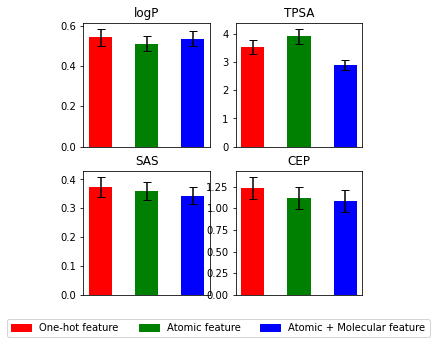

In [ ]:
title = 'Comparison of Feature Encoding; MAE'
MAE_results = [a[:,:,0], b[:,:,0], c[:,:,0]]
std= [0.1*a[:,:,1], 0.1*b[:,:,1], 0.1*c[:,:,1]]
models = ['One-hot feature', 'Atomic feature', 'Atomic + Molecular feature']
tests = ['logP', 'TPSA', 'SAS', 'CEP']
compare_encoding(MAE_results, std, models, tests,title)

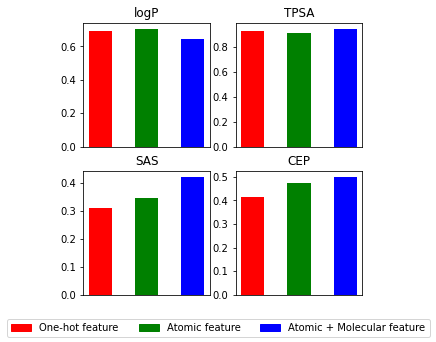

In [ ]:
title = 'Comparison of Feature Encoding; R2'
R2_results = [a[:,:,2], b[:,:,2], c[:,:,2]]
std= None
models = ['One-hot feature', 'Atomic feature', 'Atomic + Molecular feature']
tests = ['logP', 'TPSA', 'SAS', 'CEP']
compare_encoding(R2_results, std, models, tests,title)